In [1]:
%matplotlib inline
%run ../setup/nb_setup

# Science Case Studies: The Age-Velocity Dispersion Relations in GALAH DR3

Author(s): Keith Hawkins


## Learning goals

The purpose of this tutorial is to: 
1. Introduce the concepts of Age-Velocity Dispersion relations
2. Introduce Cross matching via topcat
3. Introduce/practice velocity calculations via astropy 

Goal: You will derive the Gaia DR2-GALAH Age-Velocity Dispersion relations. Two additional challenges include: (1) derive the same Age-Velocity Dispersion relations but for  Gaia DR3-GALAH (hint!: this will require a cross match) and (2) consider uncertainties in age and velocity to build a linear model which converts velocity dispersion into age.


### Notebook Setup and Package Imports

In [2]:
import numpy as np
import matplotlib.pyplot as p
import astropy
from astropy.table import Table
import scipy.stats
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import Galactic
from astropy.coordinates import ICRS
import astropy.coordinates as apycord
import random

We will need to download the GALAH DR3 dataset that contains age information. This dataset also contains DR2 estimates of velocity but *NOT* DR3 (You will need to do that cross match):

DATA LOCATION : https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR3/

Local mirror : https://users.flatironinstitute.org/~apricewhelan/data/surveys/GALAH/GALAH_DR3_VAC_ages_v2.fits

Main GALAH Table :

-GALAH_DR3_main_allstar_v2.fits -- Main GALAH DR3

-GALAH_DR3_VAC_ages_v2.fits -- GALAH DR3 ages

-GALAH_DR3_VAC_GaiaEDR3_v2.fits	-- GaiaEDR3 x GALAH


Download this dataset
and load it in with astropy!



In [3]:
GALAH = Table.read("GALAH_master_age.fits")  # loading in the data

In [4]:
# explore the columns:

print(GALAH.colnames)

['star_id', 'sobject_id_1', 'survey_name', 'flag_sp', 'teff', 'e_teff', 'irfm_teff', 'irfm_ebv', 'irfm_ebv_ref', 'logg', 'e_logg', 'fe_h', 'e_fe_h', 'flag_fe_h', 'fe_h_atmo', 'vmic', 'vbroad', 'e_vbroad', 'chi2_sp', 'alpha_fe', 'e_alpha_fe', 'nr_alpha_fe', 'flag_alpha_fe', 'ra_1', 'ra_error', 'dec_1', 'dec_error', 'l', 'b', 'r_est', 'r_lo', 'r_hi', 'r_len', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'rv_galah', 'e_rv_galah', 'parallax', 'parallax_error', 'ruwe', 'phot_g_mean_mag', 'dr2_source_id', 'dr3_source_id', 'magnitude_difference', 'proper_motion_propagation', 'solution_id', 'designation', 'random_index', 'ref_epoch', 'ra_edr3', 'ra_error_edr3', 'dec_edr3', 'dec_error_edr3', 'parallax_edr3', 'parallax_error_edr3', 'parallax_over_error', 'pm', 'pmra_edr3', 'pmra_error_edr3', 'pmdec_edr3', 'pmd

The goal here is to determine how velocity (and velocity dispersion) is correlated with age. 

As such we will need to find the (precomputed DR2) velocity columns; and age columns (based on the cell above). 

Not all velociities and ages are measured with the same precision so we will also want to apply some very simple quality control cuts. So lets do that in the next cell

In [5]:
# lets create a quality
v_err_lim = 5  # define the limiting velocity uncertinaty in all axes
age_err_lim = 0.3  # age uncertainty limit in percent
dist_err_lim = 0.15  # distance error in percent
GALAH = GALAH[
    GALAH["parallax_edr3"] > 0
]  # Makes sure no distances will be zero for astropy later

# Quality cuts
ok = np.where(
    (GALAH["vR_Rzphi_50"] - GALAH["vR_Rzphi_5"] < v_err_lim)
    & (GALAH["vT_Rzphi_50"] - GALAH["vT_Rzphi_5"] < v_err_lim)
    & (GALAH["vz_Rzphi_50"] - GALAH["vz_Rzphi_5"] < v_err_lim)
    & (GALAH["e_age_bstep"] / GALAH["age_bstep"] < age_err_lim)
    & (GALAH["parallax_error"] / GALAH["parallax"] < dist_err_lim)
    & (GALAH["age_bstep"] > 1)
    & (GALAH["age_bstep"] < 10)
)[0]

print("There are %i stars that pass the quality controls" % len(ok))
D = GALAH[ok]

There are 204089 stars that pass the quality controls


With the 'quality' sample in hand, lets now try to figure out how velocity and velocity dispersion depends on age in this sample. We will start by simply plotting velocity in all directions as a function of age.

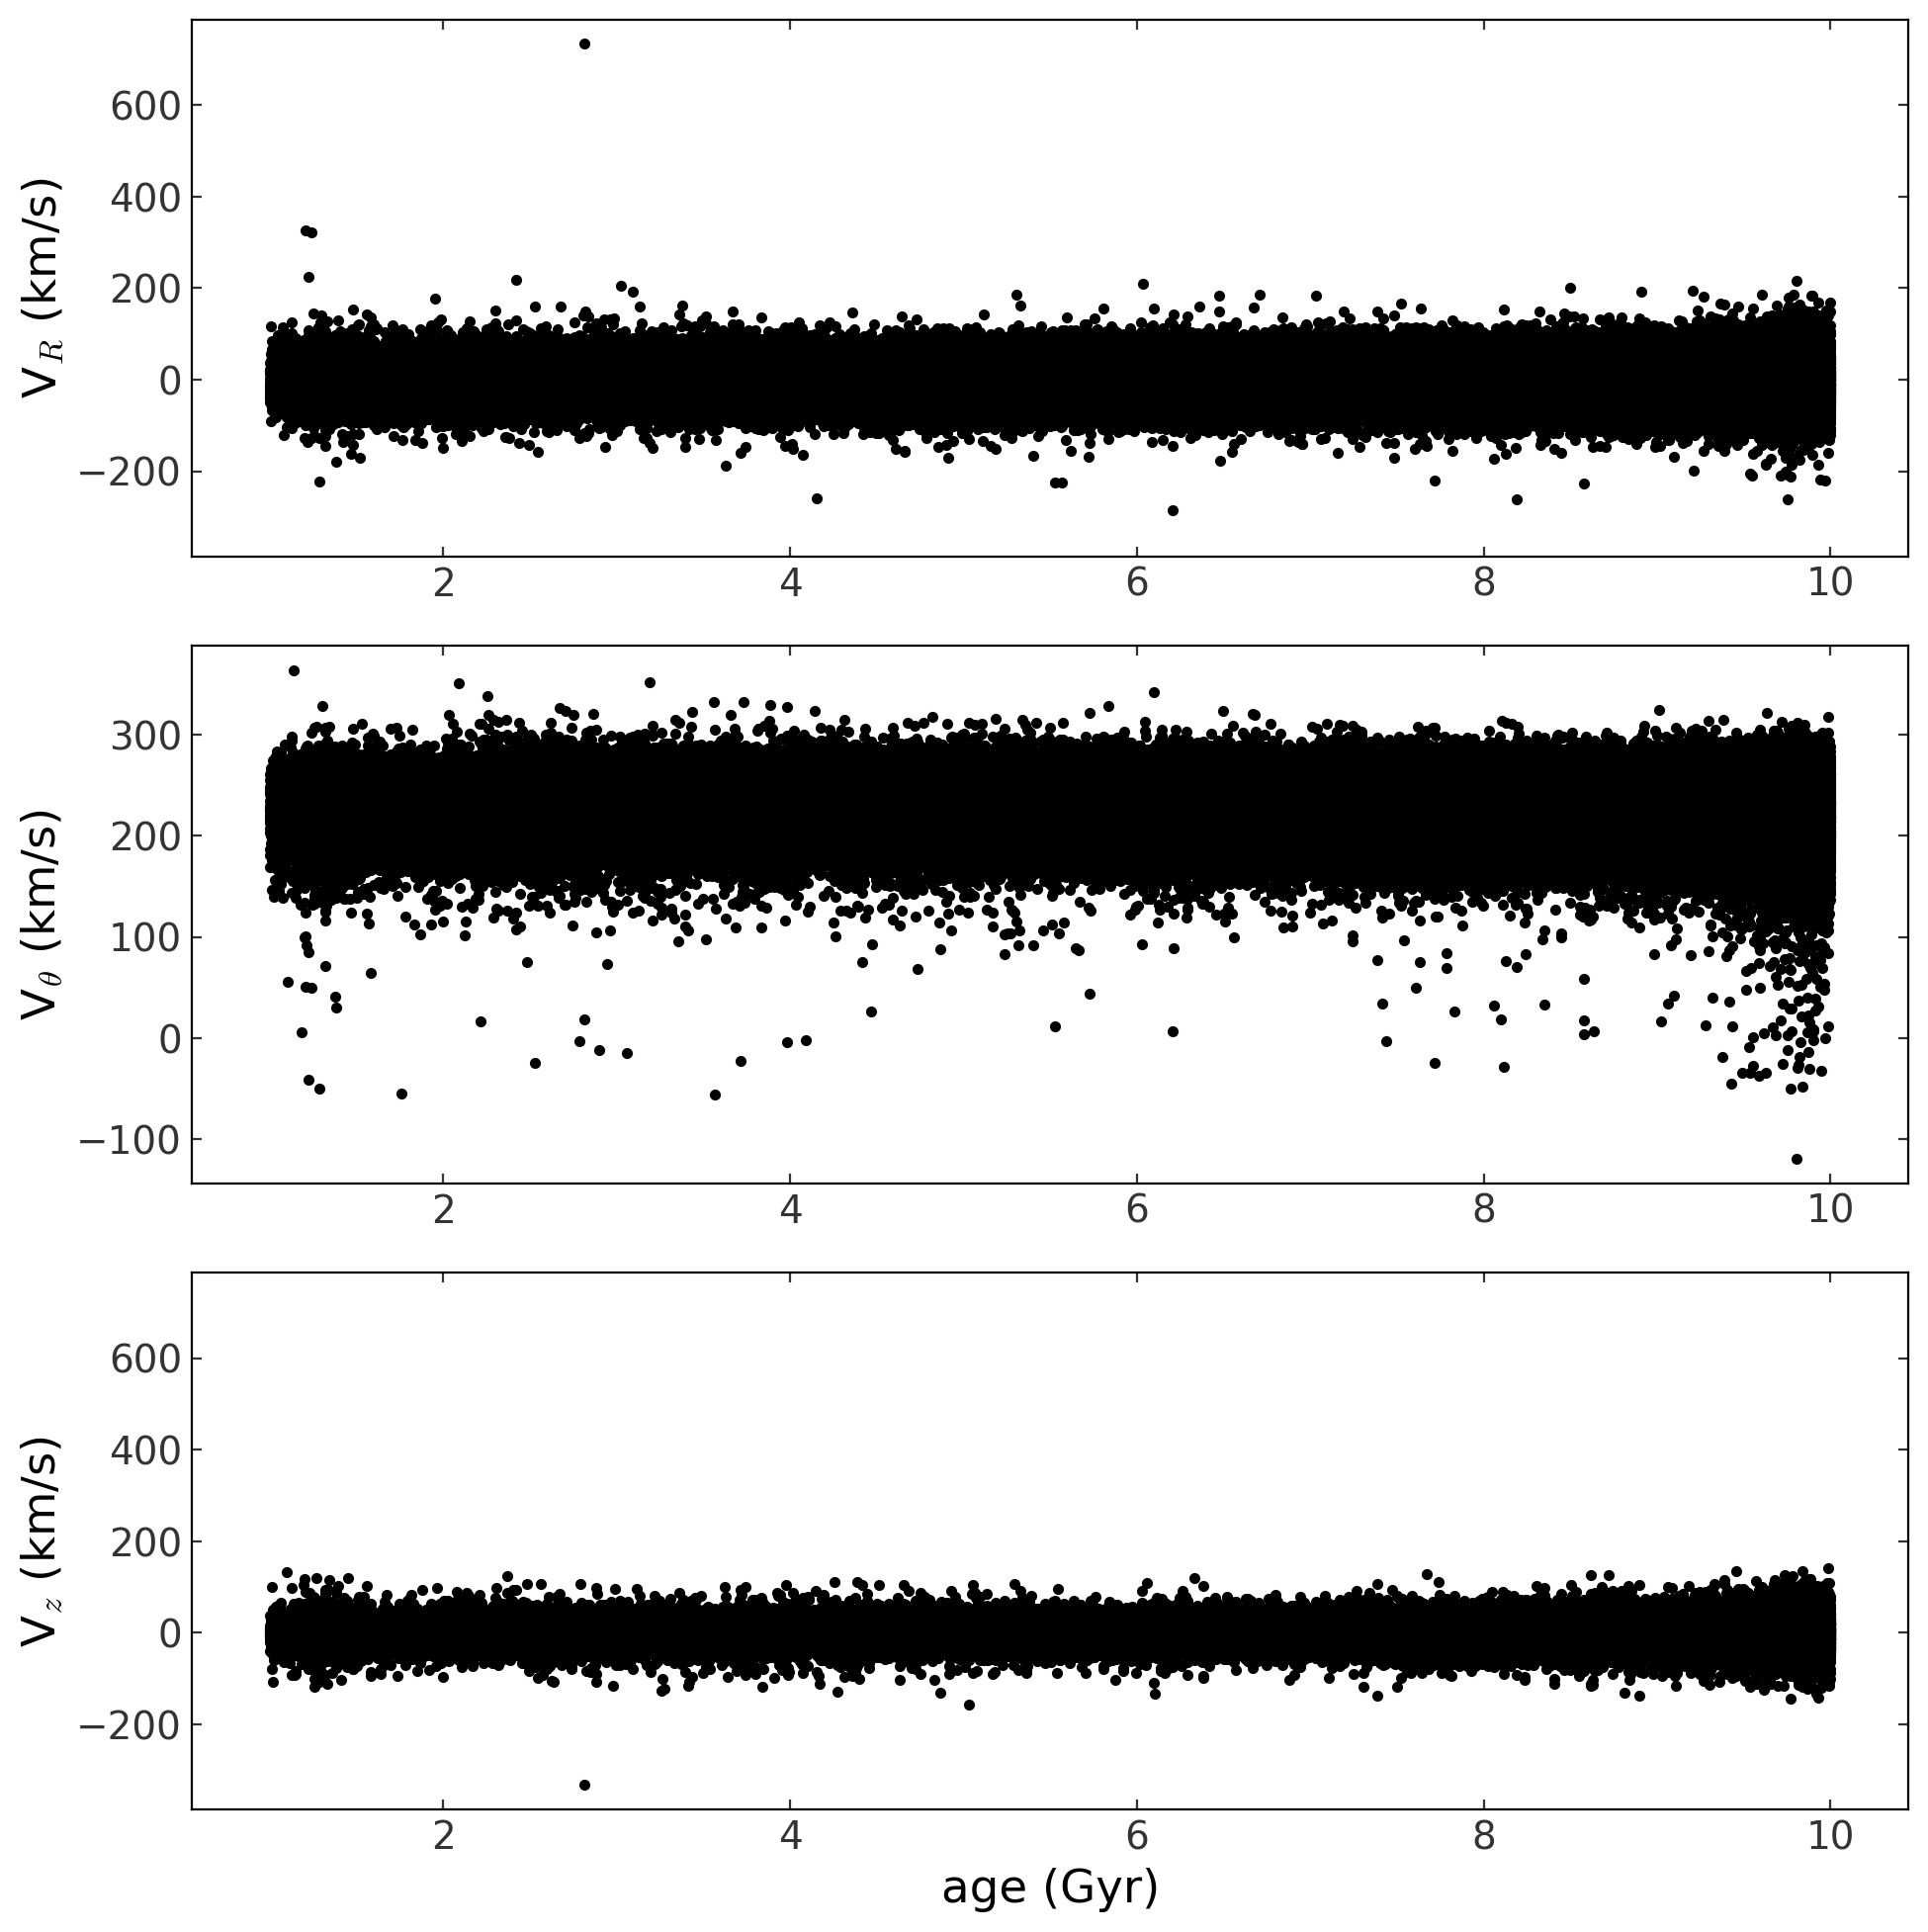

In [6]:
# Now we want to plot how the velocities depends on age
p.figure(figsize=(10, 10))
ax1 = p.subplot(3, 1, 1)
p.plot(D["age_bstep"], D["vR_Rzphi_50"], "k.")
p.ylabel("V$_R$ (km/s)")

ax2 = p.subplot(3, 1, 2, sharex=ax1)
p.plot(D["age_bstep"], D["vT_Rzphi_50"], "k.")
p.ylabel(r"V$_{\theta}$ (km/s)")

ax3 = p.subplot(3, 1, 3, sharey=ax1)
p.plot(D["age_bstep"], D["vz_Rzphi_50"], "k.")
p.ylabel("V$_z$ (km/s)")
p.xlabel("age (Gyr)")
p.tight_layout()

From the above plots we can see that:
1. Mostly velocities are indepdent of age (no signficant relationships), except maybe in V_theta
2. The velocity dispersion in all velcoity directons likley grows with increasing age

So lets bin by age and see if we can determine the relationship between age and velocity.

In [7]:
# for each star we will place them into bins by age using scipy.stats.binned_statistic

age_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # define the limits of each bin

## With the ages now binned up lets plot compute the bin's mean age and dispersion in age for each velocity direction
mean_VR, bin_edge, inds = scipy.stats.binned_statistic(
    D["age_bstep"], D["vR_Rzphi_50"], statistic="mean", bins=age_bins
)
std_VR, bin_edge, inds = scipy.stats.binned_statistic(
    D["age_bstep"], D["vR_Rzphi_50"], statistic="std", bins=age_bins
)

mean_Vz, bin_edge, inds = scipy.stats.binned_statistic(
    D["age_bstep"], D["vz_Rzphi_50"], statistic="mean", bins=age_bins
)
std_Vz, bin_edge, inds = scipy.stats.binned_statistic(
    D["age_bstep"], D["vz_Rzphi_50"], statistic="std", bins=age_bins
)

mean_Vt, bin_edge, inds = scipy.stats.binned_statistic(
    D["age_bstep"], D["vT_Rzphi_50"], statistic="mean", bins=age_bins
)
std_Vt, bin_edge, inds = scipy.stats.binned_statistic(
    D["age_bstep"], D["vT_Rzphi_50"], statistic="std", bins=age_bins
)

bincen = [
    (bin_edge[i + 1] + bin_edge[i]) / 2.0 for i in range(len(age_bins) - 1)
]  # this set the bin centers

Now that we have binned the data and determined the mean and dispersion in each velocity direction, as a sanity check (which are incredibly important to do), lets overplot the data and the binned results to ensure it looks ok.

# The Age-Velocity Dispersion Relations in GALAH-Gaia DR2


Now we are ready to plot the age velocity disperison relations for each component for GALAH-Gaia DR2. 

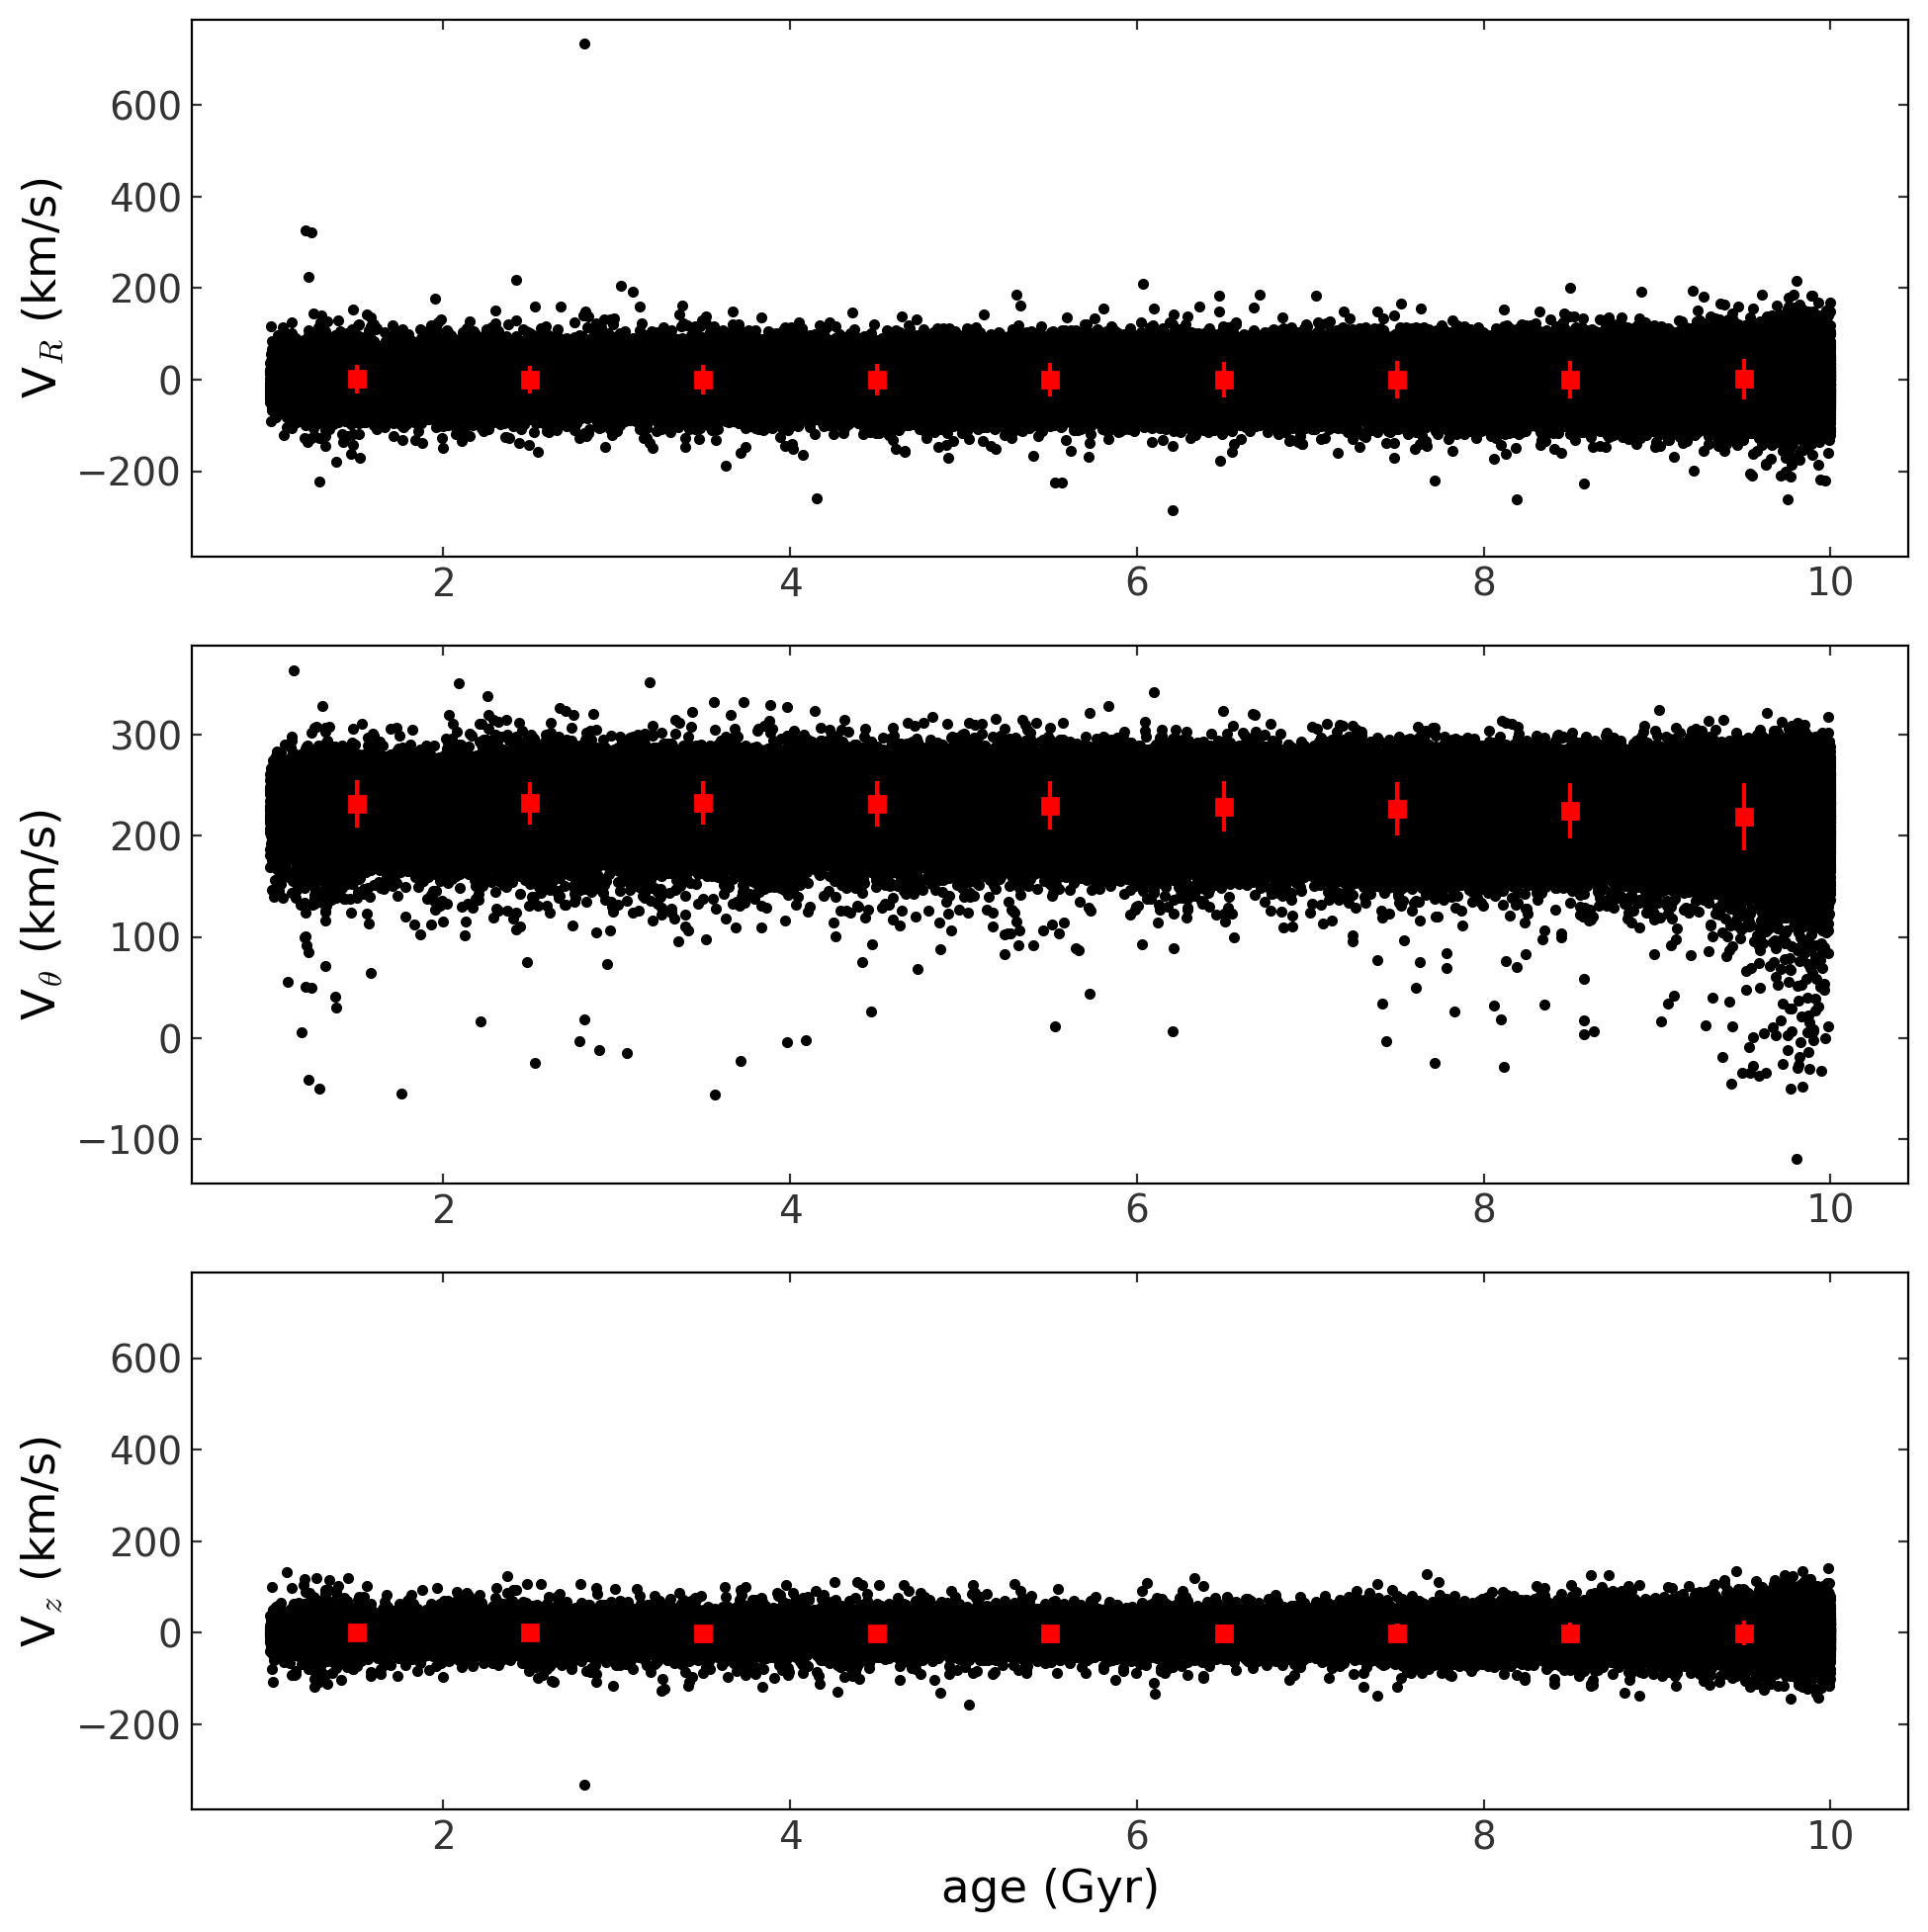

In [8]:
p.figure(figsize=(10, 10))
ax1 = p.subplot(3, 1, 1)
p.plot(D["age_bstep"], D["vR_Rzphi_50"], "k.")
p.errorbar(bincen, mean_VR, yerr=std_VR, fmt="s", color="r", zorder=3)
p.ylabel("V$_R$ (km/s)")

ax2 = p.subplot(3, 1, 2, sharex=ax1)
p.plot(D["age_bstep"], D["vT_Rzphi_50"], "k.")
p.errorbar(bincen, mean_Vt, yerr=std_Vt, fmt="s", color="r", zorder=3)
p.ylabel(r"V$_{\theta}$ (km/s)")

ax3 = p.subplot(3, 1, 3, sharey=ax1)
p.plot(D["age_bstep"], D["vz_Rzphi_50"], "k.")
p.errorbar(bincen, mean_Vz, yerr=std_Vz, fmt="s", color="r", zorder=3)
p.ylabel("V$_z$ (km/s)")
p.xlabel("age (Gyr)")
p.tight_layout()

With the data binned we can now explore the velocity disperison as a function of age

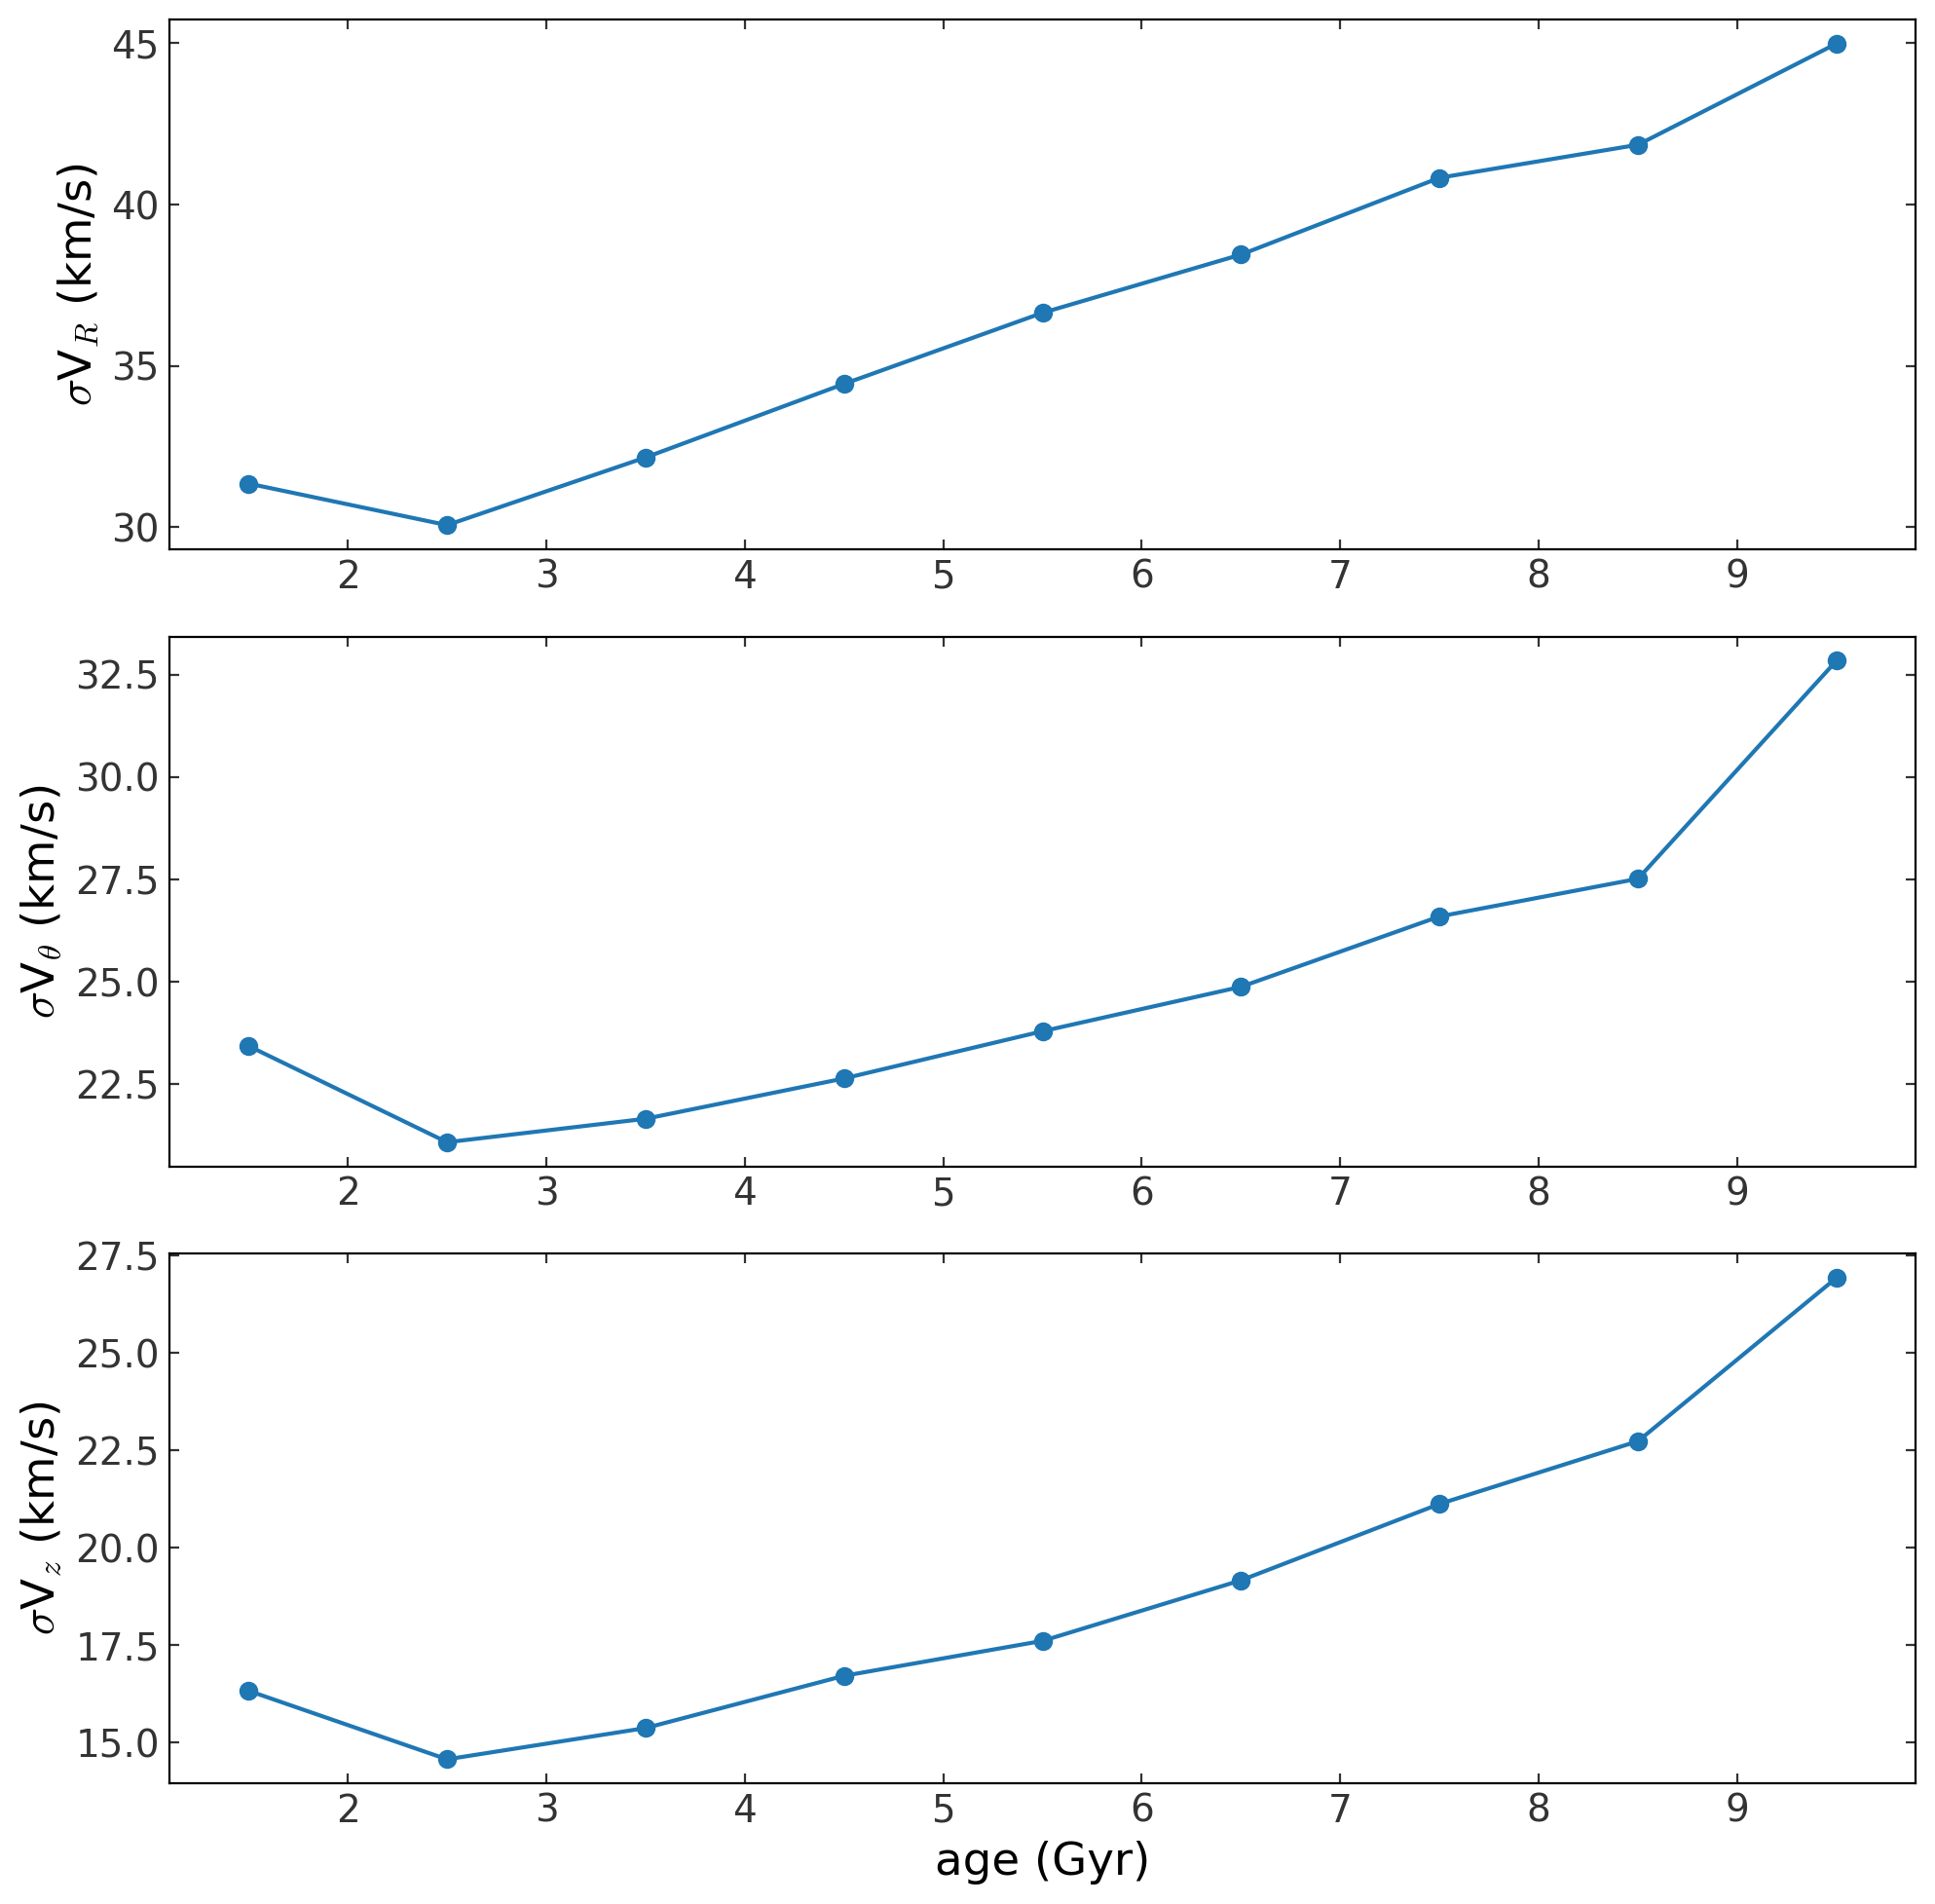

In [9]:
p.figure(figsize=(10, 10))
ax1 = p.subplot(3, 1, 1)
p.plot(bincen, std_VR, "-o")
p.ylabel(r"$\sigma$V$_R$ (km/s)")

ax2 = p.subplot(3, 1, 2, sharex=ax1)
p.plot(bincen, std_Vt, "-o")
p.ylabel(r"$\sigma$V$_{\theta}$ (km/s)")

ax1 = p.subplot(3, 1, 3, sharex=ax1)
p.plot(bincen, std_Vz, "-o")
p.ylabel(r"$\sigma$V$_z$ (km/s)")
p.xlabel("age (Gyr)")
p.tight_layout()

*We now see that the age-velocity dispersion relations are roughly linear such that VELOCITY DISPERSION INCREASES with INCREASING age as expect*

# The Age-Velocity Dispersion Relations in GALAH-Gaia EDR3!

Let us now redo the above but with EDR3 data instead! This will require us to compute the velocities (and their uncertainties -- challenge) from the EDR3 data directly.

You will need to first cross-match (via ADQL/TOPCAT/TAP QUERY/ASTROQUERY) orginal table with ED3. We will explore how to use topcat in this workshop but its trivial to do this via an ADQL/TAP Query.

Once the cross match is done, lets read it in.

In [10]:
# --- ok lets now compute some velocities with EDR3 data! We start by making a defintion.
def compute_vels(ra, dec, pmra, pmdec, rv, dist, V0=[11.1, 245.0, 7.25], R0=8.3):
    icrs = ICRS(
        ra=ra * u.deg,
        dec=dec * u.deg,
        distance=dist * u.kpc,
        pm_ra_cosdec=pmra * u.mas / u.yr,
        pm_dec=pmdec * u.mas / u.yr,
        radial_velocity=rv * u.km / u.s,
    )

    # Define the Galactic non-rotating rest frame: (V0 = solar velocity in Galactic rest fram; R0 = solar radius)
    v_sun = apycord.CartesianDifferential(V0 * u.km / u.s)
    gc_frame = apycord.Galactocentric(
        galcen_distance=R0 * u.kpc, z_sun=25.0 * u.pc, galcen_v_sun=v_sun
    )
    # convert to GC frame
    cg = icrs.transform_to(gc_frame)
    # cg.representation= 'cartesian'
    cg.representation = "cylindrical"  # and now to clylindrical coords
    VR = cg.d_rho.to(u.km / u.s).value
    VT = (
        (cg.d_phi * cg.rho).to(u.km / u.s, equivalencies=u.dimensionless_angles()).value
    )
    VZ = cg.d_z.to(u.km / u.s).value

    return VR, -VT, VZ

With the definition, we can now convert the observables into velocities by calling the defintion from above. We can also do this iterativley where in each iteration we perturb the input observables by the uncertainties. This will enable us to estimate the velocity uncertainties via monte carlo realizations.

In [11]:
# ----lets now deal with the velocity uncertinaties via monte carlo realizations

allVR = []
allVT = []
allVZ = []
niter = 50
for i in range(niter):
    pmra_perturb = np.random.normal(0, GALAH["pmra_error_edr3"])
    pmdec_perturb = np.random.normal(0, GALAH["pmdec_error_edr3"])
    rv_perturb = np.random.normal(0, GALAH["e_rv_galah"])
    parallax_perturb = np.random.normal(0, GALAH["parallax_error_edr3"])

    parallaxes = np.array(GALAH["parallax"]) + parallax_perturb
    parallaxes[
        parallaxes < 0
    ] = np.nan  # replace all negative parallaxes to 0.01 mas (again just for tutorial; you can actually infer alot from neg. parallax)

    A = compute_vels(
        np.array(GALAH["ra_edr3"]),
        np.array(GALAH["dec_edr3"]),
        np.array(GALAH["pmra_edr3"] + pmra_perturb),
        np.array(GALAH["pmdec_edr3"] + pmdec_perturb),
        np.array(GALAH["rv_galah"] + rv_perturb),
        1.0 / (parallaxes),
    )
    allVR.append(A[0])
    allVT.append(A[1])
    allVZ.append(A[2])

GALAH["galvr_dr3"] = np.median(allVR, axis=0)
GALAH["galvr_err_dr3"] = np.std(allVR, axis=0)
GALAH["galvt_dr3"] = np.median(allVT, axis=0)
GALAH["galvt_err_dr3"] = np.std(allVT, axis=0)
GALAH["galvz_dr3"] = np.median(allVZ, axis=0)
GALAH["galvz_err_dr3"] = np.std(allVZ, axis=0)

Now that we have the velocities and their uncertainties with EDR3 data, lets make the same quality control cuts as before.

In [12]:
ok = np.where(
    (GALAH["galvr_err_dr3"] < v_err_lim)
    & (GALAH["galvt_err_dr3"] < v_err_lim)
    & (GALAH["galvz_err_dr3"] < v_err_lim)
    & (GALAH["e_age_bstep"] / GALAH["age_bstep"] < age_err_lim)
    & (GALAH["parallax_error"] / GALAH["parallax"] < dist_err_lim)
    & (GALAH["age_bstep"] > 1)
    & (GALAH["age_bstep"] < 10)
)[0]

print("There are %i stars that pass the quality controls" % len(ok))
D_DR3 = GALAH[ok]

There are 208162 stars that pass the quality controls


We can now plot the EDR3 version of the age velocity relations.

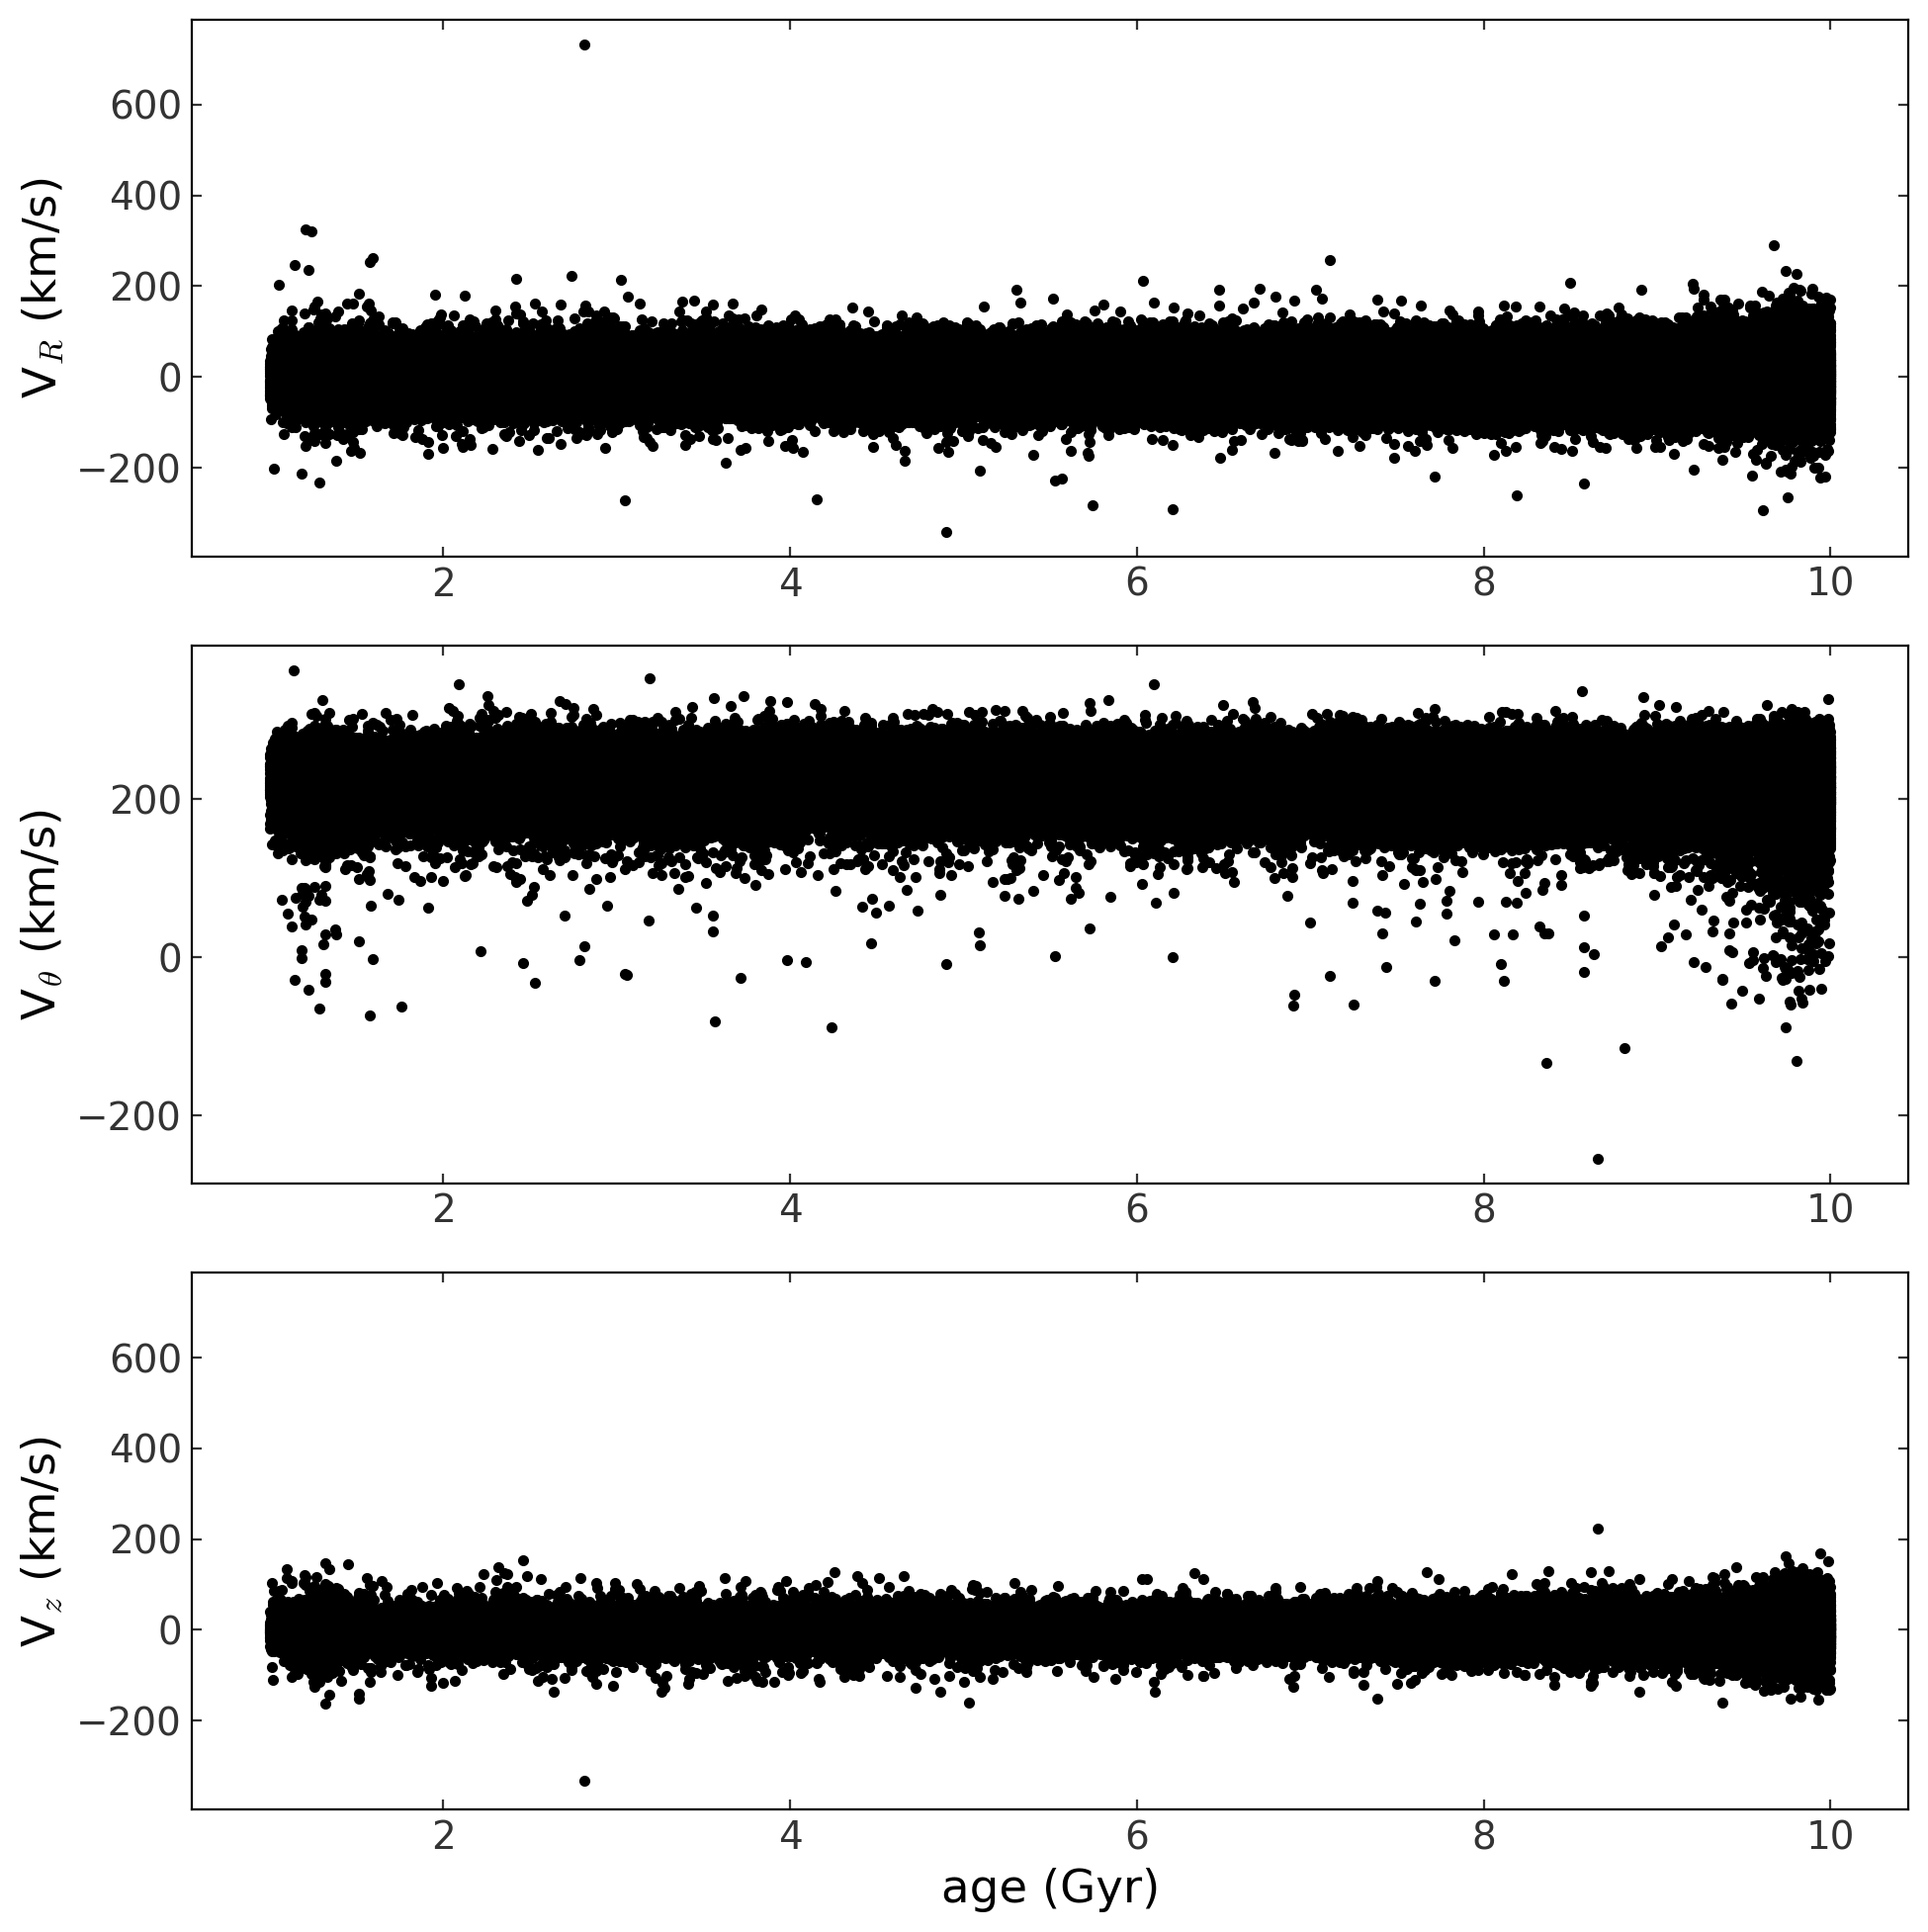

In [13]:
p.figure(figsize=(10, 10))
ax1 = p.subplot(3, 1, 1)
p.plot(D_DR3["age_bstep"], D_DR3["galvr_dr3"], "k.")
# p.errorbar(bincen,mean_VR,yerr=std_VR, fmt='s',color='r',zorder=3 )
p.ylabel("V$_R$ (km/s)")

ax2 = p.subplot(3, 1, 2, sharex=ax1)
p.plot(D_DR3["age_bstep"], D_DR3["galvt_dr3"], "k.")
# p.errorbar(bincen,mean_Vt,yerr=std_Vt, fmt='s',color='r',zorder=3 )
p.ylabel(r"V$_{\theta}$ (km/s)")

ax3 = p.subplot(3, 1, 3, sharey=ax1)
p.plot(D_DR3["age_bstep"], D_DR3["galvz_dr3"], "k.")
# p.errorbar(bincen,mean_Vz,yerr=std_Vz, fmt='s',color='r',zorder=3 )
p.ylabel("V$_z$ (km/s)")
p.xlabel("age (Gyr)")
p.tight_layout()

We must now bin the data in the same way (by age) as for the DR3 results and compute the mean and std of the velocity in each age bin.

In [14]:
mean_VR_dr3, bin_edge, inds = scipy.stats.binned_statistic(
    D_DR3["age_bstep"], D_DR3["galvr_dr3"], statistic="mean", bins=age_bins
)
std_VR_dr3, bin_edge, inds = scipy.stats.binned_statistic(
    D_DR3["age_bstep"], D_DR3["galvr_dr3"], statistic="std", bins=age_bins
)

mean_Vz_dr3, bin_edge, inds = scipy.stats.binned_statistic(
    D_DR3["age_bstep"], D_DR3["galvz_dr3"], statistic="mean", bins=age_bins
)
std_Vz_dr3, bin_edge, inds = scipy.stats.binned_statistic(
    D_DR3["age_bstep"], D_DR3["galvz_dr3"], statistic="std", bins=age_bins
)

mean_Vt_dr3, bin_edge, inds = scipy.stats.binned_statistic(
    D_DR3["age_bstep"], D_DR3["galvt_dr3"], statistic="mean", bins=age_bins
)
std_Vt_dr3, bin_edge, inds = scipy.stats.binned_statistic(
    D_DR3["age_bstep"], D_DR3["galvt_dr3"], statistic="std", bins=age_bins
)

bincen = [
    (bin_edge[i + 1] + bin_edge[i]) / 2.0 for i in range(len(age_bins) - 1)
]  # this set the bin centers

Finally, we plot the age velocity dispersion relations for GALAH-DR2 and GALAH-EDR3 datasets. 

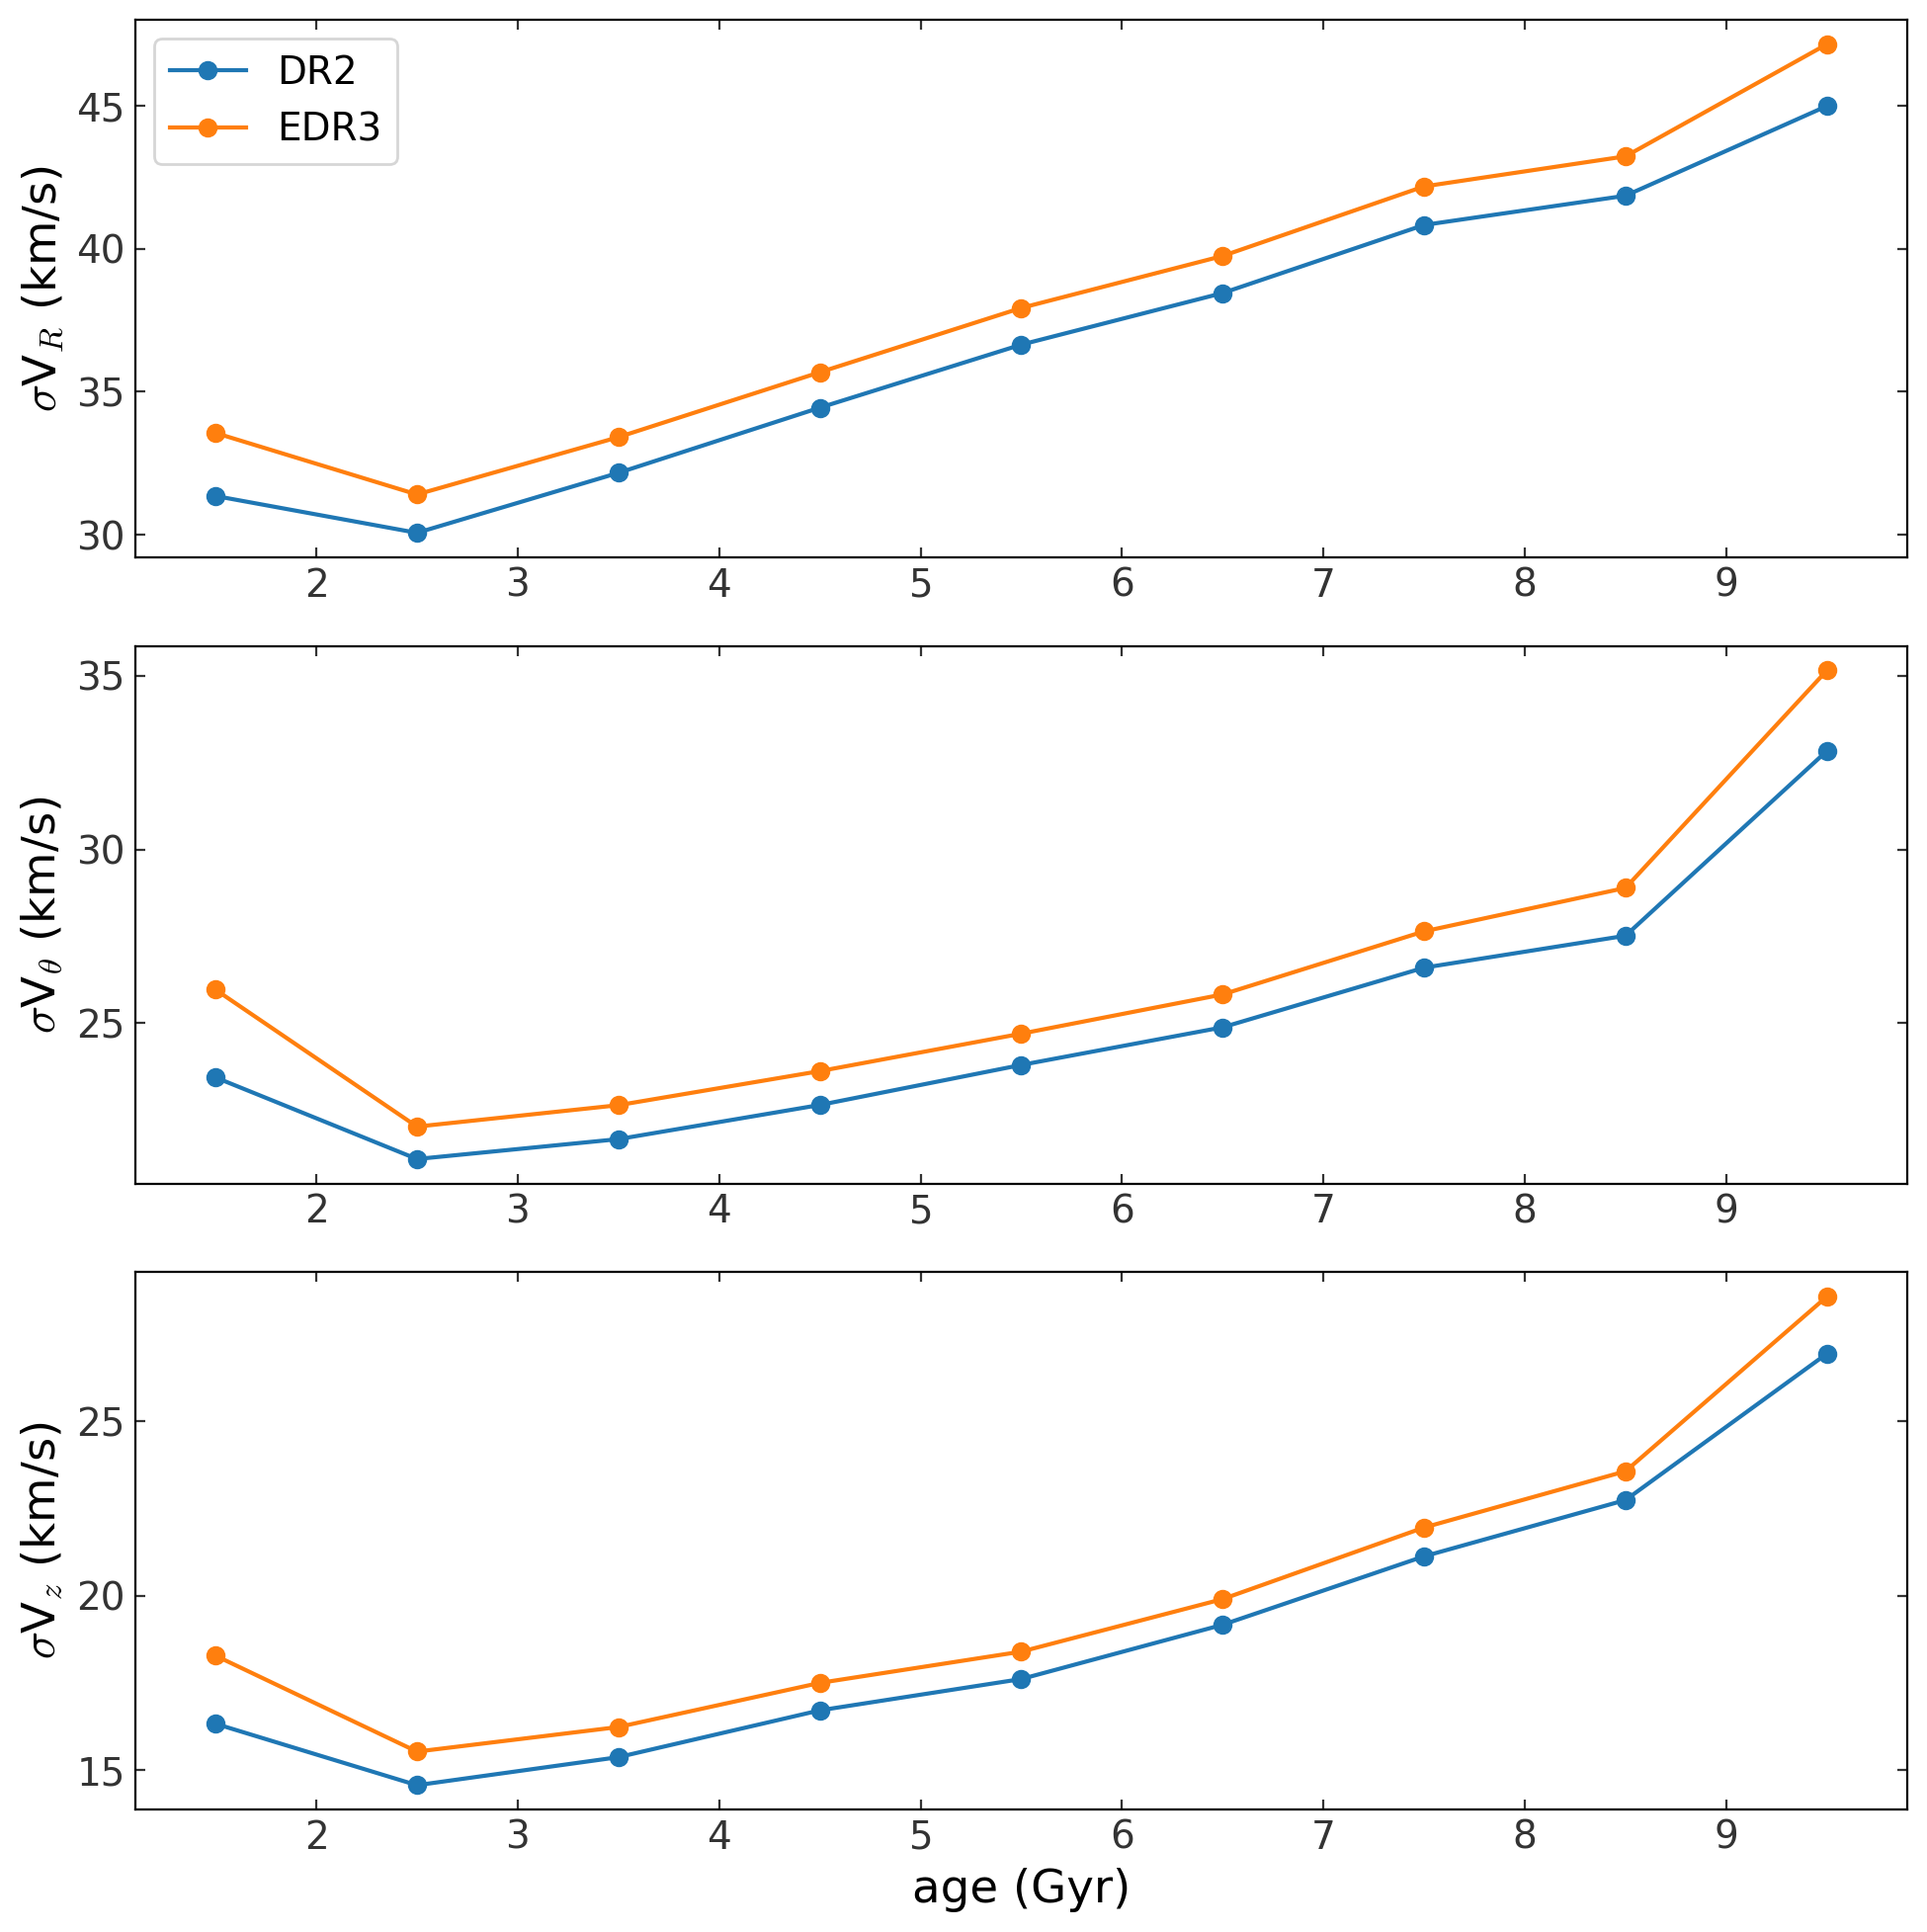

In [15]:
p.figure(figsize=(10, 10))
ax1 = p.subplot(3, 1, 1)
p.plot(bincen, std_VR, "-o", label="DR2")
p.plot(bincen, std_VR_dr3, "-o", label="EDR3")
p.legend()
p.ylabel(r"$\sigma$V$_R$ (km/s)")

ax2 = p.subplot(3, 1, 2, sharex=ax1)
p.plot(bincen, std_Vt, "-o", label="DR2")
p.plot(bincen, std_Vt_dr3, "-o", label="EDR3")
p.ylabel(r"$\sigma$V$_{\theta}$ (km/s)")

ax1 = p.subplot(3, 1, 3, sharex=ax1)
p.plot(bincen, std_Vz, "-o")
p.plot(bincen, std_Vz_dr3, "-o", label="EDR3")
p.ylabel(r"$\sigma$V$_z$ (km/s)")
p.xlabel("age (Gyr)")
p.tight_layout()

*We now see that the age-velocity dispersion relations are roughly linear such that VELOCITY DISPERSION INCREASES with INCREASING age as expected. If there are some differences between DR2 and EDR3, why might they exist.*

# Reach Challenge I: Fitting the Age-Velocity & Age-Velocity Dispersion Relations Simultaneously with Linear Model and MCMC 

Challenge: If you finish, try to figure out a way to define the age velocity relation *without* binning the data. (Hint: This can be done via writing down a linear model for how velocity dispersion depends on age and then comparing that model in the data space.)

In [16]:
# so lets begin this by importing the required packages to fit the age velocity relation 
import emcee
import corner
import scipy
import scipy.stats

So we need to write down a model 

So we will model the velocity distribution as a function of age such that

$$V_i = m_{V_i-age} * age + b_{V_i-age}$$

where i represents the velocity component (i.e., i = {r, T, z} ), $m_{V_i-age}$ (called m in code) represents the slope of the age-velocity relation, and $b_{V_i-age}$ (called b2 in the code) represents the intercept of the age-velocity relation

Additionally, we will mdoel the velocity dispersion distribtion as a function of age such that:

$$\sigma V_i = m_{\sigma V_i-age} * age + b_{\sigma V_i-age}$$

Here, $m_{\sigma V_i-age}$ (called m in the code) represents the slope of the age-velocity disperison relation, and $b_{\sigma V_i-age}$ (called b in the code) represents the intercept of the age-velocity dispersion relation

Now that we have written down a linear model, which describes how both velocity and velocity disperison depends on age, we will need to fit the model to the data. Remember that the data we have is the measured velocities ($V_i$).

We will do this in a Bayesian way.

So lets quickly recap. 

Bayes theorm states that the probability of our model given the data that we have observed (i.e., $p(\theta∣data)$, the postieror) is proportional to the probility of measuring the data that we do given the model ($p(data∣\theta)$ often called the liklihood function) multiplied by the prior information we have that our model parameters are correct ($p(\theta)$, the prior). This is mathematically,

$$p(\theta∣data) \propto  p(data | \theta) * p(\theta) $$

In our specific case, $\theta$ represents our model parameters. Thus  $\theta$ = { $m_{V_i-age}$, $b_{V_i-age}$, $m_{\sigma V_i-age}$, $b_{\sigma V_i-age}$ }.

ultimately, we need to fit these model parameters by maximizing the posterior of the model. From above we can see that we can do this by maximizing the product between the liklihood and the prior. 

With this info in hand, lets write down our priors and likihood function.

$$ p(data | \theta) = \mathcal{N}(m_{V_i-age}*age+ b_{V_i-age}, sqrt(m_{\sigma V_i-age}*age+ b_{\sigma V_i-age} + \sigma_{V_i}) $$

and we set priors such that $m_{\sigma V_i-age}$, $b_{\sigma V_i-age}$ > 0 (i.e., the slope and intercept of the age velocity dispersion relations must be posititve to ensure that the velocity dispersion is in fact larger than 0. 

Now that we have all the background and info we need, lets go ahead and begin to write down our model, log likihood function, prior and emcee instance to fit the model via MCMC



In [17]:
def lnlike1(params,age, vel, vel_err):
    #our liklihood function is a Guassian where the velocities are evaluated as a Guassian PDF where the mean of the Guassian 
    #is mean = m2*age+b2 and the velocity dispersion of the Guassian is modeled as sigma = np.sqrt( (m*age+b)**2+ (vel_err**2))
    # (i.e., the dispersion is modeled as the linear model with age added in quadrater with the uncertainty)
    #m, b = m_{V_i-age}, b_{V_i-age}
    #m2, b2 = m_{\sigma V_i-age}, b_{\sigma V_i-age}
    
    m, b,m2,b2 = params
    scale = np.sqrt( (m*age+b)**2+ (vel_err**2)) #modeling the velocity dispersion as a linear function of age and velocity errr
    loc = m2*age+b2 #modelling the mean velocity of Guassian as a linear function of age
    P=scipy.stats.norm.logpdf(vel,loc=loc,scale=scale) #evaluate the model at measured velocities with scipy stats logpdf 
    return np.sum(P) #sum the log probabilities


def lnprior1(params,age):
    m,b,m2,b2 = params 
    #uniform priors but assume that m,b > 0 (b/c they must be posititve) and m2,b2 
    if (0 < m < 50 and 0 < b < 1E2 and -1E2 < m2 < 1E2 and -1E3 < b2 < 1E3 and all(m*age+b > 0)): 
        return 0.0
    return -np.inf

def lnprob1(params, age, vel, vel_err):
    lp = lnprior1(params,age)
    return lp + lnlike1(params,age,vel, vel_err) if np.isfinite(lp) else -np.inf #add the prior and log likihood together


#lets now initialize and emcee MCMC instance.
initial = np.array([2,5,0,0 ]) #lets start with some random starting points
nwalkers=10 #10 walkers to randomly explore the space via MCMC

ndim = len(initial)
p0 = [np.array(initial) +  0.5* np.random.randn(ndim)
      for i in range(nwalkers)] #initalize the walkers
data = (np.array(D_DR3["age_bstep"]), np.array(D_DR3["galvz_dr3"]),np.array(D_DR3["galvz_err_dr3"])) #lets add the data


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args=data) #set up the sampler

print("Running burn-in...") #lets burn in first
p0, _, _ = sampler.run_mcmc(p0, 100)
sampler.reset()

print("Running production...") #lets do our last run.
sampler.run_mcmc(p0, 1000,progress=True)


Running burn-in...


  0%|          | 0/1000 [00:00<?, ?it/s]

Running production...


100%|██████████| 1000/1000 [02:30<00:00,  6.63it/s]


State([[ 1.29448184 12.69628411 -0.09773251 -0.44331229]
 [ 1.27492797 12.83036306 -0.07663187 -0.39924767]
 [ 1.28285848 12.88124747 -0.09889643 -0.38641717]
 [ 1.26679403 12.85607047 -0.11107524 -0.28209975]
 [ 1.28819132 12.71921429 -0.06656859 -0.51958682]
 [ 1.27218863 12.85590932 -0.09981806 -0.38885194]
 [ 1.2874842  12.75207753 -0.08290728 -0.38093138]
 [ 1.27976376 12.82545168 -0.09637782 -0.39532515]
 [ 1.27970263 12.79617837 -0.10936536 -0.30710891]
 [ 1.28503631 12.7862799  -0.07209015 -0.48531812]], log_prob=[-915911.17932033 -915912.09569261 -915912.70242021 -915910.38063772
 -915912.19943016 -915908.87424285 -915911.45413979 -915908.67513659
 -915909.11507336 -915910.096041  ], blobs=None, random_state=('MT19937', array([3473353202, 1649924461, 3928280023,  113764909, 1047967654,
       2215012035,  594640571, 2007024979, 1207308838, 3225083252,
       1530613866,  461970918, 3492418959, 1532509081, 1430214041,
       2817838041, 2725346625,  441205387, 4065519321,  9295

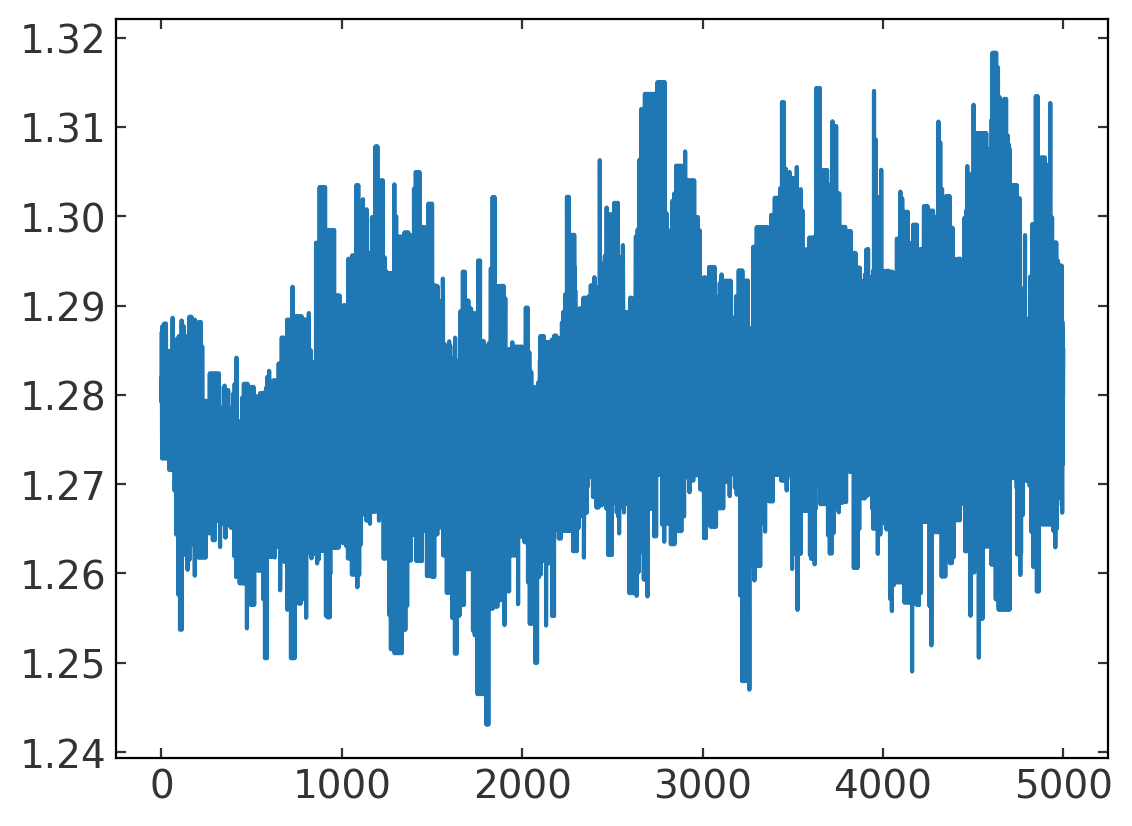

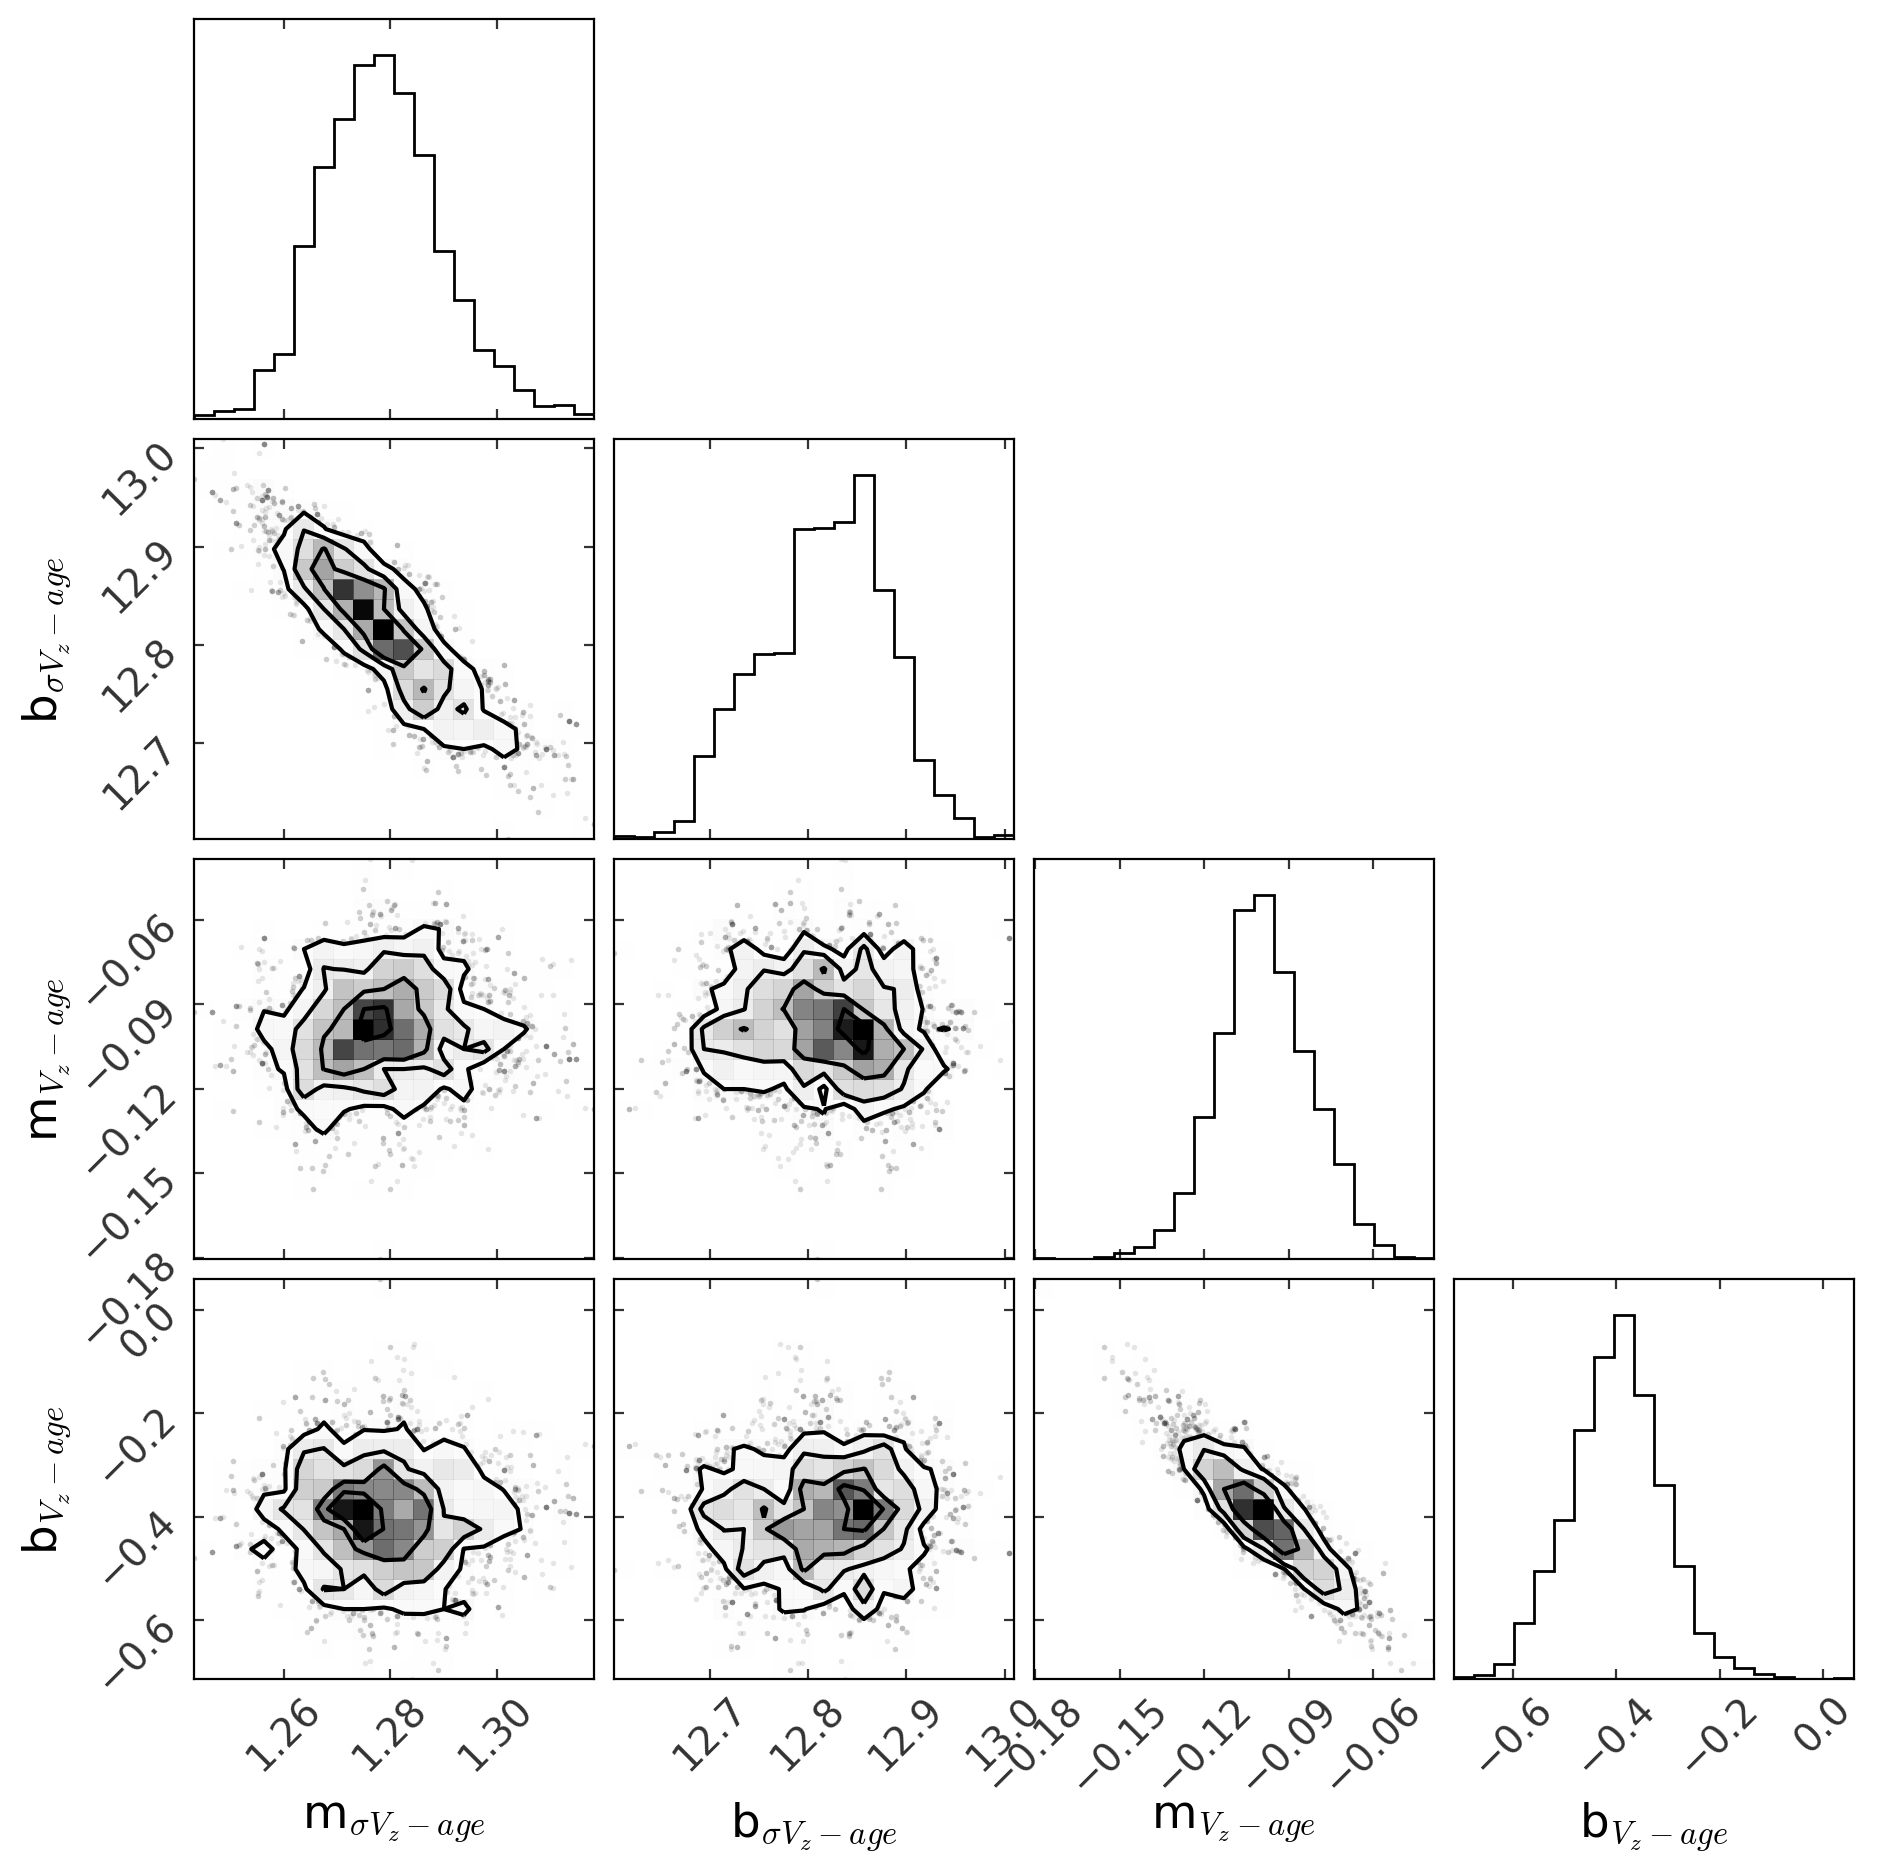

In [18]:
#--lets flatten the samples and make the corner plot to see our results.
flat_samples = sampler.get_chain(discard=500, flat=True)
p.plot(flat_samples[:,0]) #in case you want to see one of the chains to make sure its converged.
labels = [r'm$_{\sigma V_z-age}$',r'b$_{\sigma V_z-age}$','m$_{V_z-age}$','b$_{V_z-age}$']
fig = corner.corner(flat_samples, labels=labels,)

In [19]:
print('Now we see that the slope of the age-velocity dispersion (Z) relation is %.2f +/- \
%.2f km/s per Gyr FOR GALAH'%(np.median(flat_samples[:,0]),np.std(flat_samples[:,0])))


print('Finally, we find that the slope of the age-velocity (Z) relation is %.2f +/- \
%.2f km/s per Gyr FOR GALAH'%(np.median(flat_samples[:,2]),np.std(flat_samples[:,2])))



Now we see that the slope of the age-velocity dispersion (Z) relation is 1.28 +/- 0.01 km/s per Gyr FOR GALAH
Finally, we find that the slope of the age-velocity (Z) relation is -0.10 +/- 0.02 km/s per Gyr FOR GALAH


## Challenge II: If we want to measure the age of an unknown population of stars, is it better to use the Age-velocity dispersion (in Z) relation or the Age-velocity relation (in theta)?

To answer this question we must determine whether the slope of the Age-velocity relation in theta is steeper (or not) compared to the age-velocity dispersion relation in Z. Whichever has the steeper slope changes more drastically with age and is thus a 'better' relation to use. So lets refit our above model for VT

In [22]:
#lets now initialize a new emcee MCMC instance.
initial = np.array([3,5,-6,230 ]) #lets start with some random starting points
nwalkers=10 #10 walkers to randomly explore the space via MCMC

ndim = len(initial)
p0 = [np.array(initial) +  0.5* np.random.randn(ndim)
      for i in range(nwalkers)] #initalize the walkers
data = (np.array(D_DR3["age_bstep"]), np.array(D_DR3["galvt_dr3"]),np.array(D_DR3["galvt_err_dr3"])) #lets add the data


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args=data) #set up the sampler

print("Running burn-in...") #lets burn in first
p0, _, _ = sampler.run_mcmc(p0, 1000)
sampler.reset()

print("Running production...") #lets do our last run.
sampler.run_mcmc(p0, 1000,progress=True)


Running burn-in...


  0%|          | 0/1000 [00:00<?, ?it/s]

Running production...


100%|██████████| 1000/1000 [02:48<00:00,  5.94it/s]


State([[  1.19141458  19.69191994  -1.50904377 232.70197891]
 [  1.19712521  19.67460087  -1.5129462  232.49220622]
 [  1.20553099  19.6195822   -1.52431627 232.56792545]
 [  1.19732593  19.58481102  -1.48152874 232.36434602]
 [  1.21674319  19.5816961   -1.49901146 232.61100982]
 [  1.20949902  19.61611455  -1.50731958 232.67611359]
 [  1.18813264  19.80770855  -1.53389316 232.77809169]
 [  1.18016219  19.69289616  -1.52920278 232.71700189]
 [  1.18698277  19.67512272  -1.52535832 232.73550645]
 [  1.21127069  19.63020411  -1.49381257 232.46556143]], log_prob=[-975055.45672897 -975055.94076862 -975055.06695246 -975058.12492201
 -975055.46224665 -975055.20856207 -975057.64356278 -975054.76380193
 -975054.3622182  -975055.64846317], blobs=None, random_state=('MT19937', array([    669502, 3198459513, 3365997610, 3696371941, 2198629028,
       2973054149, 1112415081, 1503365096, 1265663986, 2900439184,
       1425122256,  276303783,  587239630, 1735848680, 2993302550,
       2354405871, 1

Now we see that the slope of the age-velocity dispersion (theta) relation is 1.20 +/- 0.01 km/s per Gyr FOR GALAH
Finally, we find that the slope of the age-velocity (theta) relation is -1.53 +/- 0.02 km/s per Gyr FOR GALAH


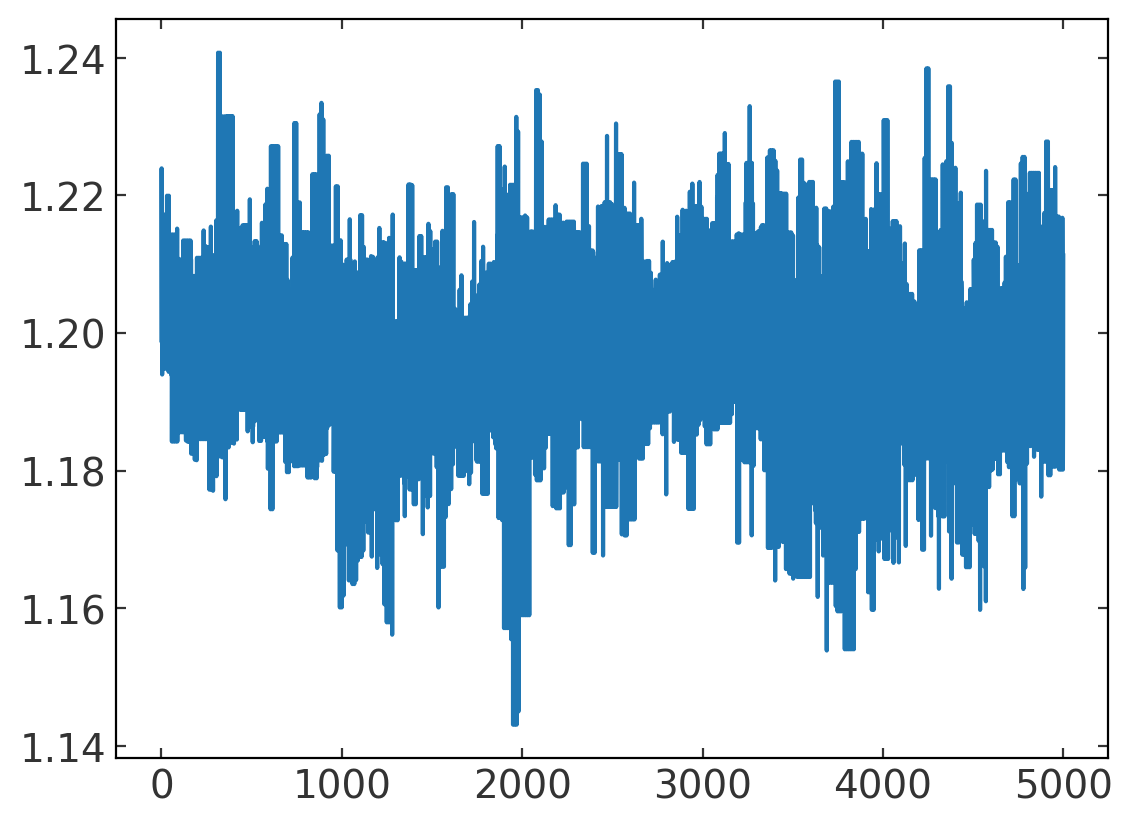

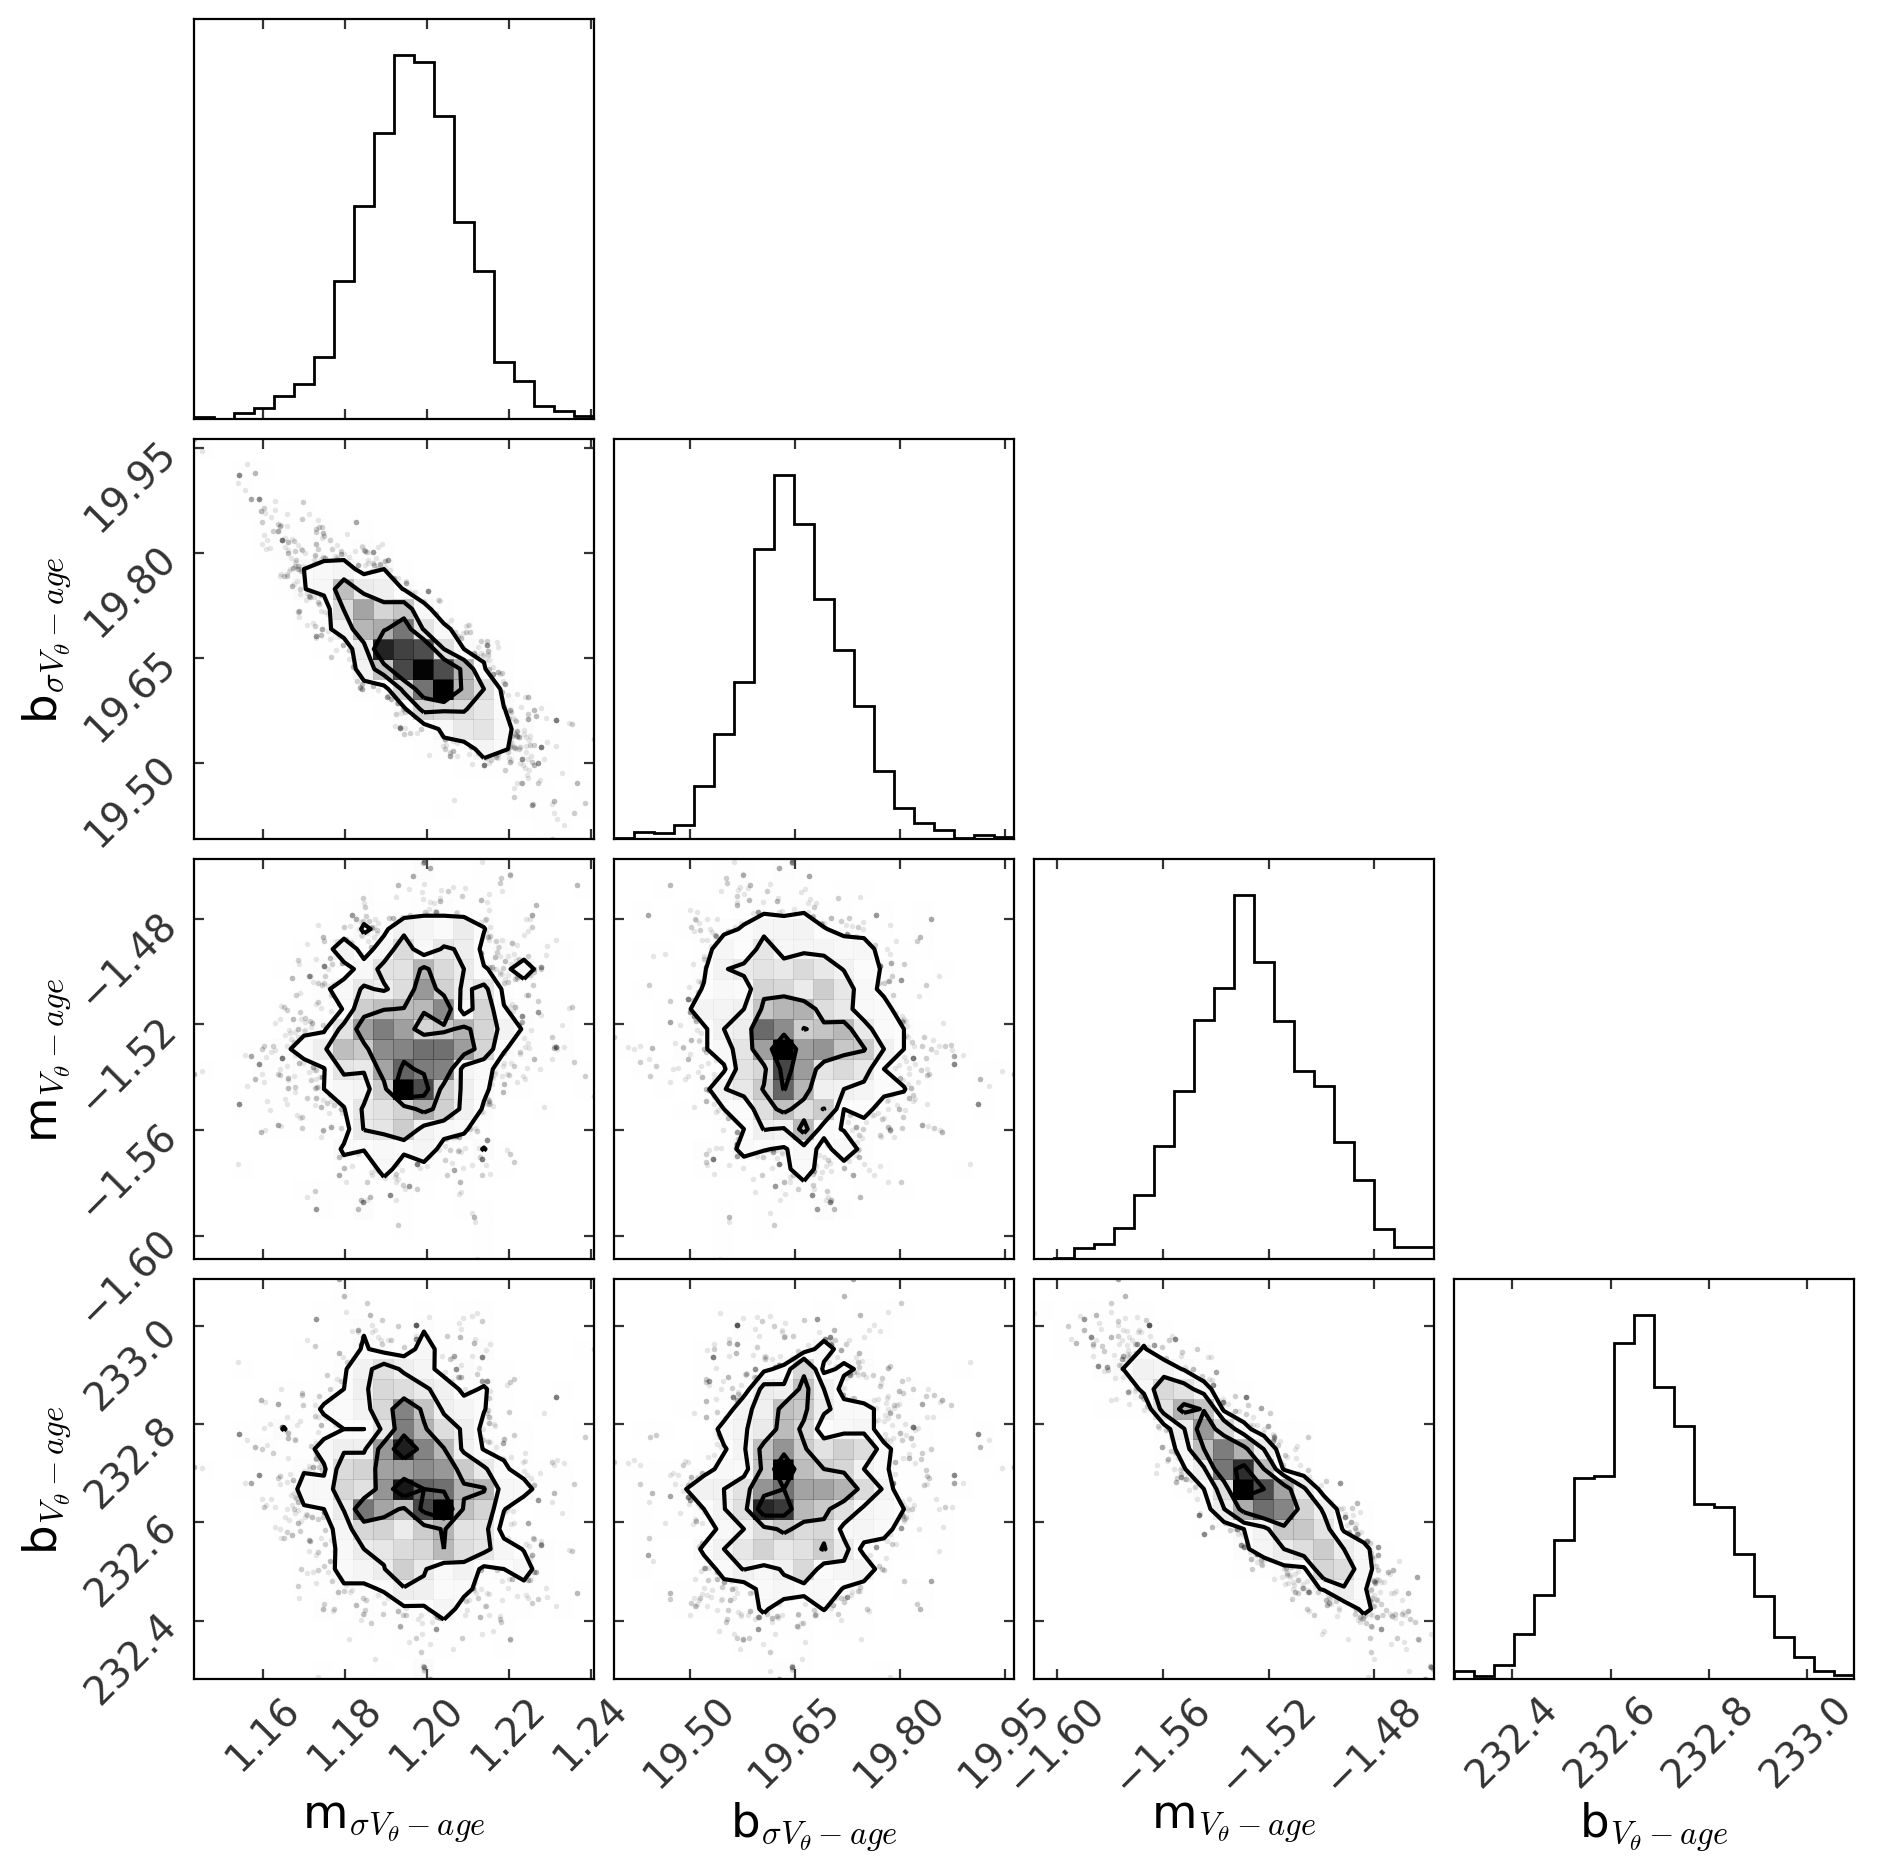

In [23]:
#--lets flatten the samples and make the corner plot to see our results.
flat_samples = sampler.get_chain(discard=500, flat=True)
p.plot(flat_samples[:,0]) #in case you want to see one of the chains to make sure its converged.
labels = [r'm$_{\sigma V_\theta-age}$',r'b$_{\sigma V_\theta-age}$',r'm$_{V_\theta-age}$',r'b$_{V_\theta-age}$']
fig = corner.corner(flat_samples, labels=labels,)

print('Now we see that the slope of the age-velocity dispersion (theta) relation is %.2f +/- \
%.2f km/s per Gyr FOR GALAH'%(np.median(flat_samples[:,0]),np.std(flat_samples[:,0])))


print('Finally, we find that the slope of the age-velocity (theta) relation is %.2f +/- \
%.2f km/s per Gyr FOR GALAH'%(np.median(flat_samples[:,2]),np.std(flat_samples[:,2])))

*Finally*, we find that the **Age-V$_\theta$ relation is actually steeper (and thus better to use) compared to the Age-V$_z$ dispersion relation (but just)**